In [81]:
input_size = (3, 189, 252)

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터

In [83]:
import numpy as np
from PIL import Image

input_images = []
labels = []
#quarternion 변환된 데이터 사용(orientation : roll, pitch, yaw -> w, x, y, z)
#orientation은 radian
'''
# Binding images and coordinates into pairs
for image_path, coord in zip(image_file_paths, coordinates):
    # Image loading and preprocessing
    image = Image.open('/content/drive/MyDrive/image/frames_resized/' + image_path) # Resize image

    #image = np.array(image) / 255.0 # Image normalization
    image = np.divide(np.array(image), 255.0)
    # Add image and coordinates to the list
    input_images.append(image)
    labels.append(coord)

# Convert list to NumPy array
input_images = np.array(input_images)
labels = np.array(labels)
np.savez('/content/drive/MyDrive/data/data_quaternion.npz', input_images=input_images, labels=labels)
'''




#loaded_data = np.load('/content/drive/MyDrive/data/data_quaternion.npz')
loaded_data = np.load('/content/drive/MyDrive/data/data_224_quaternion.npz')
#loaded_data = np.load('/content/drive/MyDrive/24-1딥러닝/data/data_quaternion.npz')
input_images = loaded_data['input_images']
labels = loaded_data['labels']

In [84]:
from sklearn.model_selection import train_test_split
# 전체 데이터를 train+val과 test로 나눕니다.
x_train_val, x_test, y_train_val, y_test = train_test_split(input_images, labels, test_size=0.2, random_state=42)

# train+val 데이터를 다시 train과 val로 나눕니다.
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# 결과적으로 전체 데이터의 60%가 train, 20%가 val, 20%가 test로 나뉩니다.

In [85]:
# Custom Dataset class
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Custom Dataset class
class PoseDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image.permute(2, 0, 1), label

train_dataset = PoseDataset(x_train, y_train)
val_dataset = PoseDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# test 평가 함수

In [86]:
test_dataset = PoseDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [87]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_position_loss = 0.0
    test_quaternion_loss = 0.0

    true_positions_list = []
    predicted_positions_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_inputs)
            loss = criterion(test_labels, outputs)

            position_loss = compute_position_loss2(test_labels, outputs)
            quaternion_loss = compute_quaternion_loss(test_labels, outputs)

            test_loss += loss.item() * test_inputs.size(0)
            test_position_loss += position_loss.item() * test_inputs.size(0)
            test_quaternion_loss += quaternion_loss.item() * test_inputs.size(0)

            true_positions_list.append(test_labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_position_loss = test_position_loss / len(test_loader.dataset)
    test_quaternion_loss = test_quaternion_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Position Loss: {test_position_loss:.4f}, Test Quaternion Loss: {test_quaternion_loss:.4f}')

    # Measure and print the metrics
    measure_metrics(model, input_size)

    return test_loss, test_position_loss, test_quaternion_loss, true_positions_list, predicted_positions_list

# 로스

In [88]:
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(weights=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = ResNet50Model(num_classes=7).to(device)

In [91]:
class LossHistory:
    def __init__(self):
        self.train_position_losses = []
        self.train_quaternion_losses = []
        self.val_position_losses = []
        self.val_quaternion_losses = []

    def on_epoch_end(self, epoch, logs):
        self.train_position_losses.append(logs['train_position_loss'])
        self.train_quaternion_losses.append(logs['train_quaternion_loss'])
        self.val_position_losses.append(logs['val_position_loss'])
        self.val_quaternion_losses.append(logs['val_quaternion_loss'])

In [92]:
!pip install thop

In [93]:
from torch.profiler import profile, record_function, ProfilerActivity
import time
from thop import profile as thop_profile

def measure_metrics(model, input_size):
    dummy_input = torch.randn(1, *input_size).to(device)

    #FLOPs&parameters
    flops, params = thop_profile(model, inputs=(dummy_input, ))

    #latency
    with torch.no_grad():
        start_time = time.time()
        model(dummy_input)
        latency = time.time() - start_time

    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")
    print(f"Latency: {latency:.6f} seconds")

In [94]:
num_epochs = 10
patience = 5
best_loss = float('inf')
epochs_no_improve = 0
optimizer = optim.Adam(base_model.parameters(), lr=1e-4)
loss_history = LossHistory()

## 그냥 mse

In [95]:
criterion = nn.MSELoss()

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

true_positions_list = []
predicted_positions_list = []

stop_training = False
actual_epochs = 0  #실제 에포크

for epoch in range(num_epochs):
    if stop_training:
        break

    base_model.train()
    train_position_loss = 0
    train_quaternion_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)

        #MSE
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        position_loss = criterion(outputs[:, :3], labels[:, :3])
        quaternion_loss = criterion(outputs[:, 3:], labels[:, 3:])

        train_position_loss += position_loss.item()
        train_quaternion_loss += quaternion_loss.item()

    train_position_loss /= len(train_loader)
    train_quaternion_loss /= len(train_loader)

    base_model.eval()
    val_position_loss = 0
    val_quaternion_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = base_model(images)

            # Store true and predicted values for visualization
            true_positions_list.append(labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

            val_position_loss += criterion(outputs[:, :3], labels[:, :3]).item()
            val_quaternion_loss += criterion(outputs[:, 3:], labels[:, 3:]).item()

    val_position_loss /= len(val_loader)
    val_quaternion_loss /= len(val_loader)

    logs = {
        'train_position_loss': train_position_loss,
        'train_quaternion_loss': train_quaternion_loss,
        'val_position_loss': val_position_loss,
        'val_quaternion_loss': val_quaternion_loss
    }
    loss_history.on_epoch_end(epoch, logs)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Position Loss: {train_position_loss}, Train Quaternion Loss: {train_quaternion_loss}, Val Position Loss: {val_position_loss}, Val Quaternion Loss: {val_quaternion_loss}")

    # Early stopping
    combined_val_loss = val_position_loss + val_quaternion_loss
    if combined_val_loss < best_loss:
        best_loss = combined_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        stop_training = True

    actual_epochs += 1

measure_metrics(base_model, input_size)

Epoch 1/10, Train Position Loss: 66.31805013150586, Train Quaternion Loss: 0.17721567652663406, Val Position Loss: 12.14307280147777, Val Quaternion Loss: 0.148984733311569
Epoch 2/10, Train Position Loss: 12.249653266400706, Train Quaternion Loss: 0.14483144955367458, Val Position Loss: 3.449968029471005, Val Quaternion Loss: 0.1326493717291776
Epoch 3/10, Train Position Loss: 6.034174992113697, Train Quaternion Loss: 0.13043174162811164, Val Position Loss: 2.3332242089159347, Val Quaternion Loss: 0.12048823627478936
Epoch 4/10, Train Position Loss: 4.601122637184298, Train Quaternion Loss: 0.11689420272501147, Val Position Loss: 1.7760010221425224, Val Quaternion Loss: 0.09968075463000466
Epoch 5/10, Train Position Loss: 2.7766526317109865, Train Quaternion Loss: 0.10520160760806531, Val Position Loss: 1.0449067932717941, Val Quaternion Loss: 0.09265017115017947
Epoch 6/10, Train Position Loss: 2.6218360625967687, Train Quaternion Loss: 0.1000644748612326, Val Position Loss: 0.900323

In [97]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_metrics(loss_history, actual_epochs):
    epochs = list(range(actual_epochs))  # Use actual epochs

    # Create subplots with 3 columns
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Combined Loss', 'Position Loss', 'Orientation Loss'))

    # Combined loss (assuming combined loss is calculated as sum of position and quaternion losses)
    combined_train_loss = [p + q for p, q in zip(loss_history.train_position_losses[:actual_epochs], loss_history.train_quaternion_losses[:actual_epochs])]
    combined_val_loss = [p + q for p, q in zip(loss_history.val_position_losses[:actual_epochs], loss_history.val_quaternion_losses[:actual_epochs])]
    fig.add_trace(go.Scatter(x=epochs, y=combined_train_loss, mode='lines', name='Training Combined Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=combined_val_loss, mode='lines', name='Validation Combined Loss'), row=1, col=1)

    # Position loss
    fig.add_trace(go.Scatter(x=epochs, y=loss_history.train_position_losses[:actual_epochs], mode='lines', name='Training Position Loss'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=loss_history.val_position_losses[:actual_epochs], mode='lines', name='Validation Position Loss'), row=1, col=2)

    # Orientation loss
    fig.add_trace(go.Scatter(x=epochs, y=loss_history.train_quaternion_losses[:actual_epochs], mode='lines', name='Training Quaternion Loss'), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=loss_history.val_quaternion_losses[:actual_epochs], mode='lines', name='Validation Quaternion Loss'), row=1, col=3)

    # Update layout
    fig.update_layout(height=600, width=1600, title_text="Training and Validation Metrics Over Epochs")
    fig.update_xaxes(title_text='Epochs')
    fig.update_yaxes(title_text='Combined Loss', row=1, col=1)
    fig.update_yaxes(title_text='Position Loss', row=1, col=2)
    fig.update_yaxes(title_text='Quaternion Loss', row=1, col=3)

    fig.show()

In [98]:
plot_metrics(loss_history, actual_epochs)

### 카메라 시각화(mse)

In [99]:
# Convert lists to numpy arrays for easier handling
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

In [100]:
# Visualization function
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly

# 예제 1
def eul2rot(heading, pitch, roll):
    """Converts Euler angles to rotation matrix: heading, pitch, roll -> rotation about Z, Y, X
    XYZ sequence or ZYX sequence - Robot or Mobile """
    heading, pitch, roll = np.deg2rad(heading), np.deg2rad(pitch), np.deg2rad(roll)
    Rz = np.array([
        [np.cos(heading), -np.sin(heading), 0],
        [np.sin(heading), np.cos(heading), 0],
        [0, 0, 1]
    ])
    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    R = Rz.dot(Ry).dot(Rx)

    return R

# 예제 2
def eul2rot(heading, pitch, roll):
    """Converts Euler angles to rotation matrix: heading, pitch, roll -> rotation about X, Y, Z
    XYZ sequence or ZYX sequence - Robot or Mobile """
    heading, pitch, roll = np.deg2rad(heading), np.deg2rad(pitch), np.deg2rad(roll)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(heading), -np.sin(heading)],
        [0, np.sin(heading), np.cos(heading)]
    ])
    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    Rz = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]
    ])
    R = Rz.dot(Ry).dot(Rx)

    return R

def plot_pose_comparison(true_positions, predicted_positions, frame_number=None):
    plt.figure(figsize=(12, 8))

    if frame_number is not None:
        # 특정 프레임에 대해서만 시각화
        true_x, true_y = true_positions[frame_number, 0], true_positions[frame_number, 1]
        pred_x, pred_y = predicted_positions[frame_number, 0], predicted_positions[frame_number, 1]

        true_end_x = true_x + np.cos(np.deg2rad(true_positions[frame_number, 3])) * 0.2
        true_end_y = true_y + np.sin(np.deg2rad(true_positions[frame_number, 3])) * 0.2
        pred_end_x = pred_x + np.cos(np.deg2rad(predicted_positions[frame_number, 3])) * 0.2
        pred_end_y = pred_y + np.sin(np.deg2rad(predicted_positions[frame_number, 3])) * 0.2

        plt.scatter([true_x], [true_y], s=100, facecolors='none', edgecolors='b', label='True')  # 실제값
        plt.scatter([pred_x], [pred_y], s=100, facecolors='none', edgecolors=(1, 0, 0, 0.3), label='Predicted')  # 예측값, 투명도 0.3

        plt.plot([true_x, true_end_x], [true_y, true_end_y], 'b-')
        plt.plot([pred_x, pred_end_x], [pred_y, pred_end_y], 'r-', alpha=0.3)  # 투명도 0.3

        plt.title(f'Comparison at Frame {frame_number}')
    else:
        # 전체 데이터 시각화
        plt.scatter(true_positions[:, 0], true_positions[:, 1], s=100, facecolors='none', edgecolors='b', label='True')  # 실제값
        plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], s=100, facecolors='none', edgecolors=(1, 0, 0, 0.3), label='Predicted')  # 예측값, 투명도 0.3

        for i in range(true_positions.shape[0]):
            true_x, true_y = true_positions[i, 0], true_positions[i, 1]
            true_end_x = true_x + np.cos(np.deg2rad(true_positions[i, 3])) * 0.2
            true_end_y = true_y + np.sin(np.deg2rad(true_positions[i, 3])) * 0.2
            plt.plot([true_x, true_end_x], [true_y, true_end_y], 'b-')

        for i in range(predicted_positions.shape[0]):
            pred_x, pred_y = predicted_positions[i, 0], predicted_positions[i, 1]
            pred_end_x = pred_x + np.cos(np.deg2rad(predicted_positions[i, 3])) * 0.2
            pred_end_y = pred_y + np.sin(np.deg2rad(predicted_positions[i, 3])) * 0.2
            plt.plot([pred_x, pred_end_x], [pred_y, pred_end_y], 'r-', alpha=0.3)  # 투명도 0.3

        plt.title('Comparison of True and Predicted Poses')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

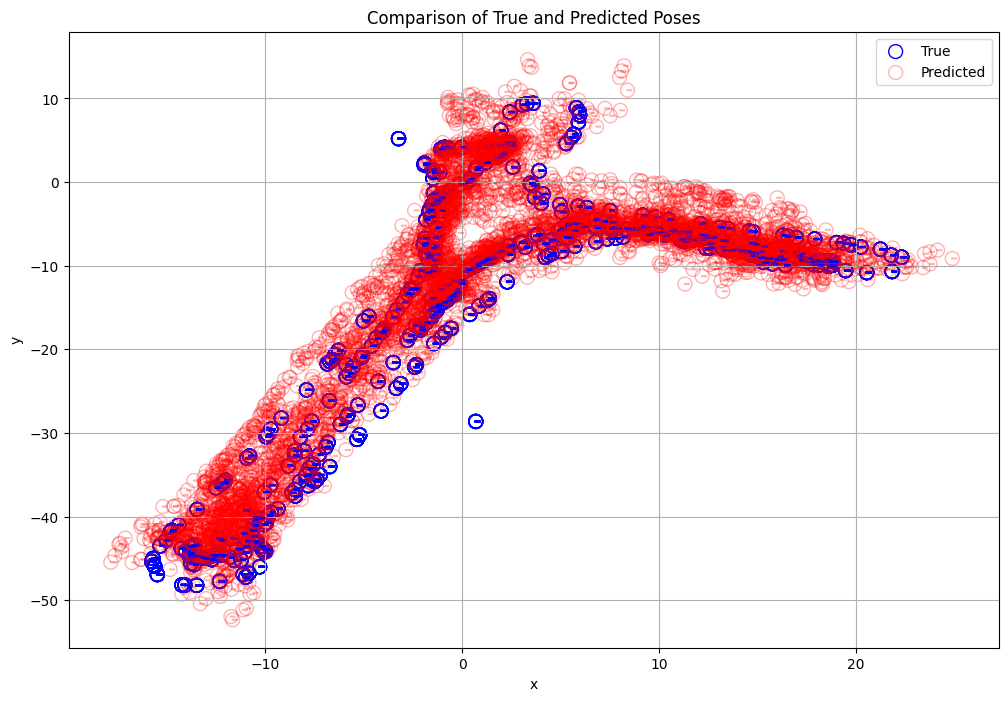

In [101]:
# 전체 데이터 비교 시각화
plot_pose_comparison(true_positions, predicted_positions)

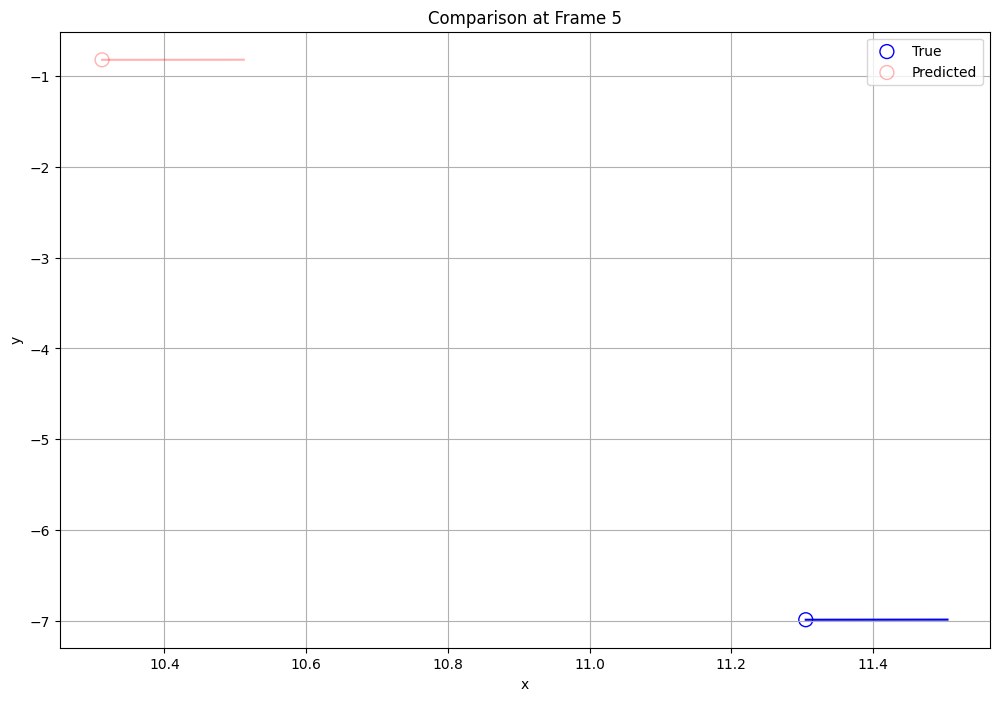

In [102]:
# 특정 프레임 비교 시각화
plot_pose_comparison(true_positions, predicted_positions, frame_number=5)

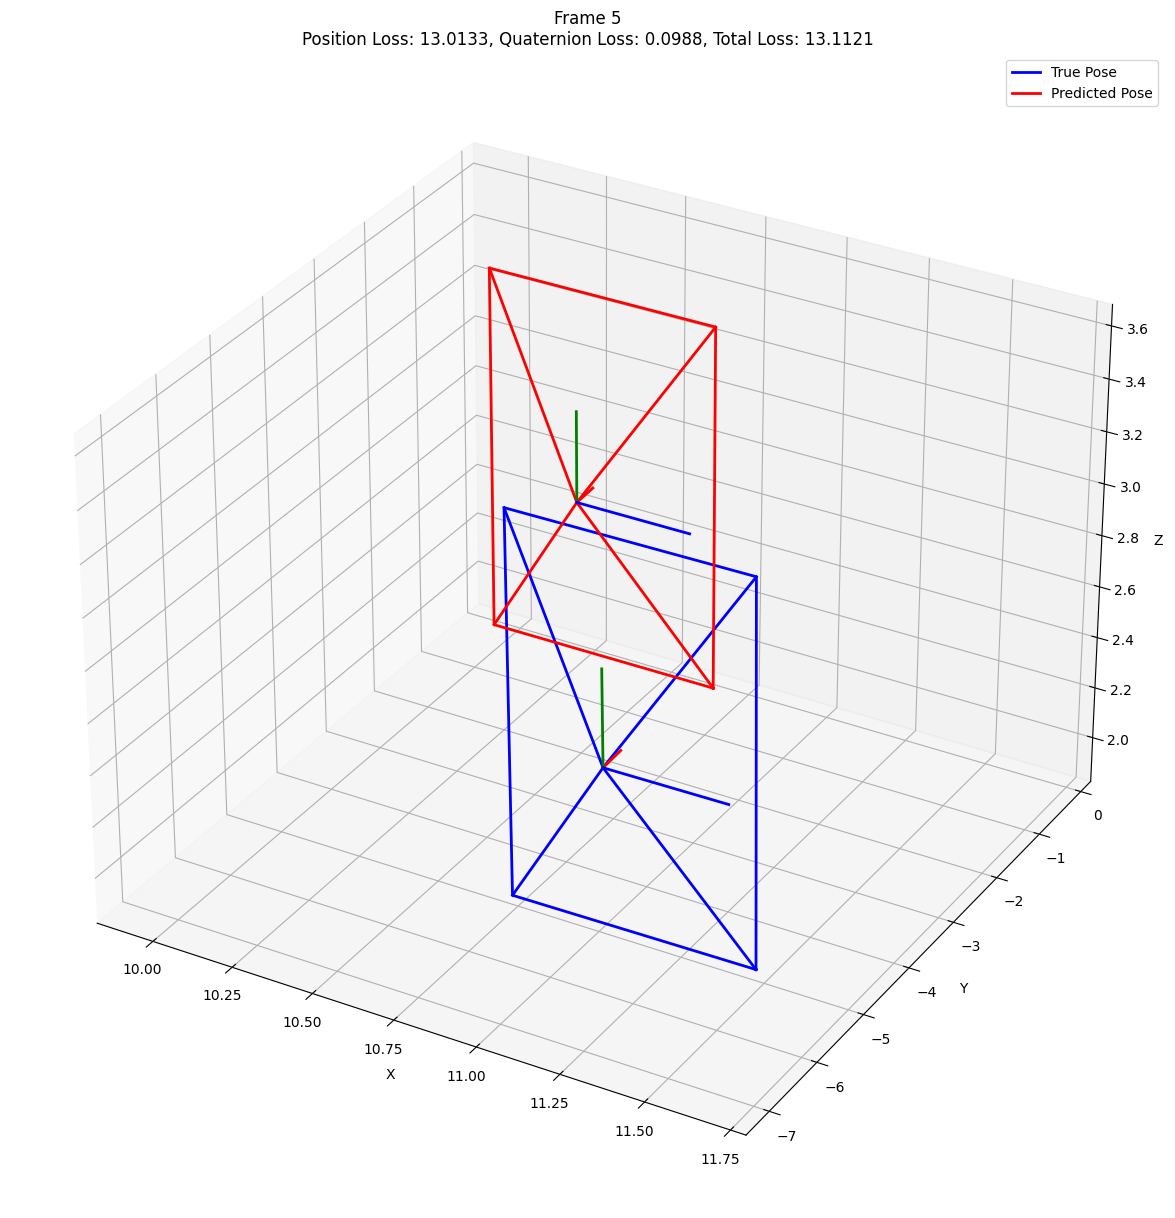

In [103]:
# Convert lists to numpy arrays for easier handling
true_positions = np.vstack(true_positions_list)
predicted_positions = np.vstack(predicted_positions_list)

# Specify the frame number to visualize
frame_number = 5

# Calculate the loss for the specified frame (using the same criterion as in the training loop)
criterion = nn.MSELoss()
position_loss = criterion(torch.tensor(predicted_positions[frame_number, :3]), torch.tensor(true_positions[frame_number, :3])).item()
quaternion_loss = criterion(torch.tensor(predicted_positions[frame_number, 3:]), torch.tensor(true_positions[frame_number, 3:])).item()
total_loss = position_loss + quaternion_loss

# Visualization
camScale = 3
camBodyColor = 'black'

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

rows = 240
cols = 480

def plot_single_frame(ax, true_pos, pred_pos, color_true='blue', color_pred='red'):
    R_gc_true = eul2rot(true_pos[3], true_pos[4], true_pos[5])
    p_gc_true = np.array([true_pos[0], true_pos[1], true_pos[2]])

    R_gc_pred = eul2rot(pred_pos[3], pred_pos[4], pred_pos[5])
    p_gc_pred = np.array([pred_pos[0], pred_pos[1], pred_pos[2]])

    camBody = np.zeros((3, 4))
    camBody[:, 0] = camScale * np.array([(rows/2), (rows-50), -(cols/2)]) / 1000
    camBody[:, 1] = camScale * np.array([-(rows/2), (rows-50), -(cols/2)]) / 1000
    camBody[:, 2] = camScale * np.array([-(rows/2), (rows-50), (cols/2)]) / 1000
    camBody[:, 3] = camScale * np.array([(rows/2), (rows-50), (cols/2)]) / 1000

    camFrame = camScale * ((rows/2) / 1000) * np.eye(3)
    Rz90 = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])
    Rx90 = np.array([
        [1, 0, 0],
        [0, 0, -1],
        [0, 1, 0]
    ])
    camFrame = Rz90.dot(Rx90).dot(camFrame)

    camBody_true = R_gc_true.dot(camBody) + p_gc_true[:, np.newaxis]
    camFrame_true = R_gc_true.dot(camFrame) + p_gc_true[:, np.newaxis]

    camBody_pred = R_gc_pred.dot(camBody) + p_gc_pred[:, np.newaxis]
    camFrame_pred = R_gc_pred.dot(camFrame) + p_gc_pred[:, np.newaxis]

    # Draw true camera body
    for i in range(4):
        ax.plot([camBody_true[0, i], p_gc_true[0]], [camBody_true[1, i], p_gc_true[1]], [camBody_true[2, i], p_gc_true[2]], color=color_true, linewidth=2, label='True Pose' if i == 0 else "")
    ax.plot(camBody_true[0, [0, 1, 2, 3, 0]], camBody_true[1, [0, 1, 2, 3, 0]], camBody_true[2, [0, 1, 2, 3, 0]], color=color_true, linewidth=2)

    # Draw true camera frame (RGB axis)
    colors = ['r', 'g', 'b']
    for i in range(3):
        ax.plot([camFrame_true[0, i], p_gc_true[0]], [camFrame_true[1, i], p_gc_true[1]], [camFrame_true[2, i], p_gc_true[2]], color=colors[i], linewidth=2)

    # Draw predicted camera body
    for i in range(4):
        ax.plot([camBody_pred[0, i], p_gc_pred[0]], [camBody_pred[1, i], p_gc_pred[1]], [camBody_pred[2, i], p_gc_pred[2]], color=color_pred, linewidth=2, label='Predicted Pose' if i == 0 else "")
    ax.plot(camBody_pred[0, [0, 1, 2, 3, 0]], camBody_pred[1, [0, 1, 2, 3, 0]], camBody_pred[2, [0, 1, 2, 3, 0]], color=color_pred, linewidth=2)

    # Draw predicted camera frame (RGB axis)
    for i in range(3):
        ax.plot([camFrame_pred[0, i], p_gc_pred[0]], [camFrame_pred[1, i], p_gc_pred[1]], [camFrame_pred[2, i], p_gc_pred[2]], color=colors[i], linewidth=2)

# Plot the single frame
plot_single_frame(ax, true_positions[frame_number], predicted_positions[frame_number])

ax.set_aspect('auto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the loss
plt.title(f'Frame {frame_number}\nPosition Loss: {position_loss:.4f}, Quaternion Loss: {quaternion_loss:.4f}, Total Loss: {total_loss:.4f}')
plt.legend()
plt.show()

## Quaternian loss - fixed beta

In [104]:
# Custom loss functions and metrics
def compute_position_loss2(y_true, y_pred):
    position_true = y_true[:, :3]
    position_pred = y_pred[:, :3]
    return torch.mean((position_pred - position_true) ** 2)

def compute_quaternion_loss(y_true, y_pred):
    epsilon = 1e-7
    quaternion_true = y_true[:, 3:]
    quaternion_pred = y_pred[:, 3:]
    quaternion_true = quaternion_true / (torch.norm(quaternion_true, dim=1, keepdim=True) + epsilon)
    quaternion_pred = quaternion_pred / (torch.norm(quaternion_pred, dim=1, keepdim=True) + epsilon)
    return torch.mean(torch.norm(quaternion_true - quaternion_pred, dim=1))

class PoseNetLoss3(nn.Module):
    def __init__(self, beta=0.5):
        super(PoseNetLoss3, self).__init__()
        self.beta = beta

    def forward(self, y_true, y_pred):
        position_loss = compute_position_loss2(y_true, y_pred)
        quaternion_loss = compute_quaternion_loss(y_true, y_pred)
        combined_loss = position_loss + self.beta * quaternion_loss
        return combined_loss

In [105]:
pose_loss_fn3 = PoseNetLoss3(beta=0.5)

In [106]:
# Training loop
num_epochs = 10
optimizer = optim.Adam(base_model.parameters(), lr=1e-4)

# For storing true and predicted values
true_positions_list = []
predicted_positions_list = []


for epoch in range(num_epochs):
    base_model.train()
    train_position_loss = 0
    train_quaternion_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)

        # Calculate losses
        position_loss = compute_position_loss2(labels, outputs)
        quaternion_loss = compute_quaternion_loss(labels, outputs)
        combined_loss = pose_loss_fn3(labels, outputs)
        combined_loss.backward()
        optimizer.step()

        train_position_loss += position_loss.item()
        train_quaternion_loss += quaternion_loss.item()

    train_position_loss /= len(train_loader)
    train_quaternion_loss /= len(train_loader)

    base_model.eval()
    val_position_loss = 0
    val_quaternion_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = base_model(images)

            # Store true and predicted values for visualization
            true_positions_list.append(labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

            val_position_loss += compute_position_loss2(labels, outputs).item()
            val_quaternion_loss += compute_quaternion_loss(labels, outputs).item()

    val_position_loss /= len(val_loader)
    val_quaternion_loss /= len(val_loader)

    logs = {
        'train_position_loss': train_position_loss,
        'train_quaternion_loss': train_quaternion_loss,
        'val_position_loss': val_position_loss,
        'val_quaternion_loss': val_quaternion_loss
    }
    loss_history.on_epoch_end(epoch, logs)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Position Loss: {train_position_loss}, Train Quaternion Loss: {train_quaternion_loss}, Val Position Loss: {val_position_loss}, Val Quaternion Loss: {val_quaternion_loss}")
# Measure and print the metrics
measure_metrics(base_model, input_size)

Epoch 1/10, Train Position Loss: 1.8329488184987281, Train Quaternion Loss: 0.40214939415454865, Val Position Loss: 0.7287738270619336, Val Quaternion Loss: 0.2951003944172579
Epoch 2/10, Train Position Loss: 1.6899783404505984, Train Quaternion Loss: 0.35593907109328676, Val Position Loss: 1.678923834772671, Val Quaternion Loss: 0.35786114720737233
Epoch 3/10, Train Position Loss: 0.9974320251114515, Train Quaternion Loss: 0.3292951255428548, Val Position Loss: 2.142745421213262, Val Quaternion Loss: 0.33707617924493904
Epoch 4/10, Train Position Loss: 0.9939467098031726, Train Quaternion Loss: 0.31839567057940427, Val Position Loss: 0.567856590537464, Val Quaternion Loss: 0.2829839324249941
Epoch 5/10, Train Position Loss: 0.9595200513698616, Train Quaternion Loss: 0.3145378618216028, Val Position Loss: 0.5097359751953798, Val Quaternion Loss: 0.29640963936553283
Epoch 6/10, Train Position Loss: 0.8961993281026276, Train Quaternion Loss: 0.280973095674904, Val Position Loss: 2.546135

### 카메라 시각화(fixed beta)

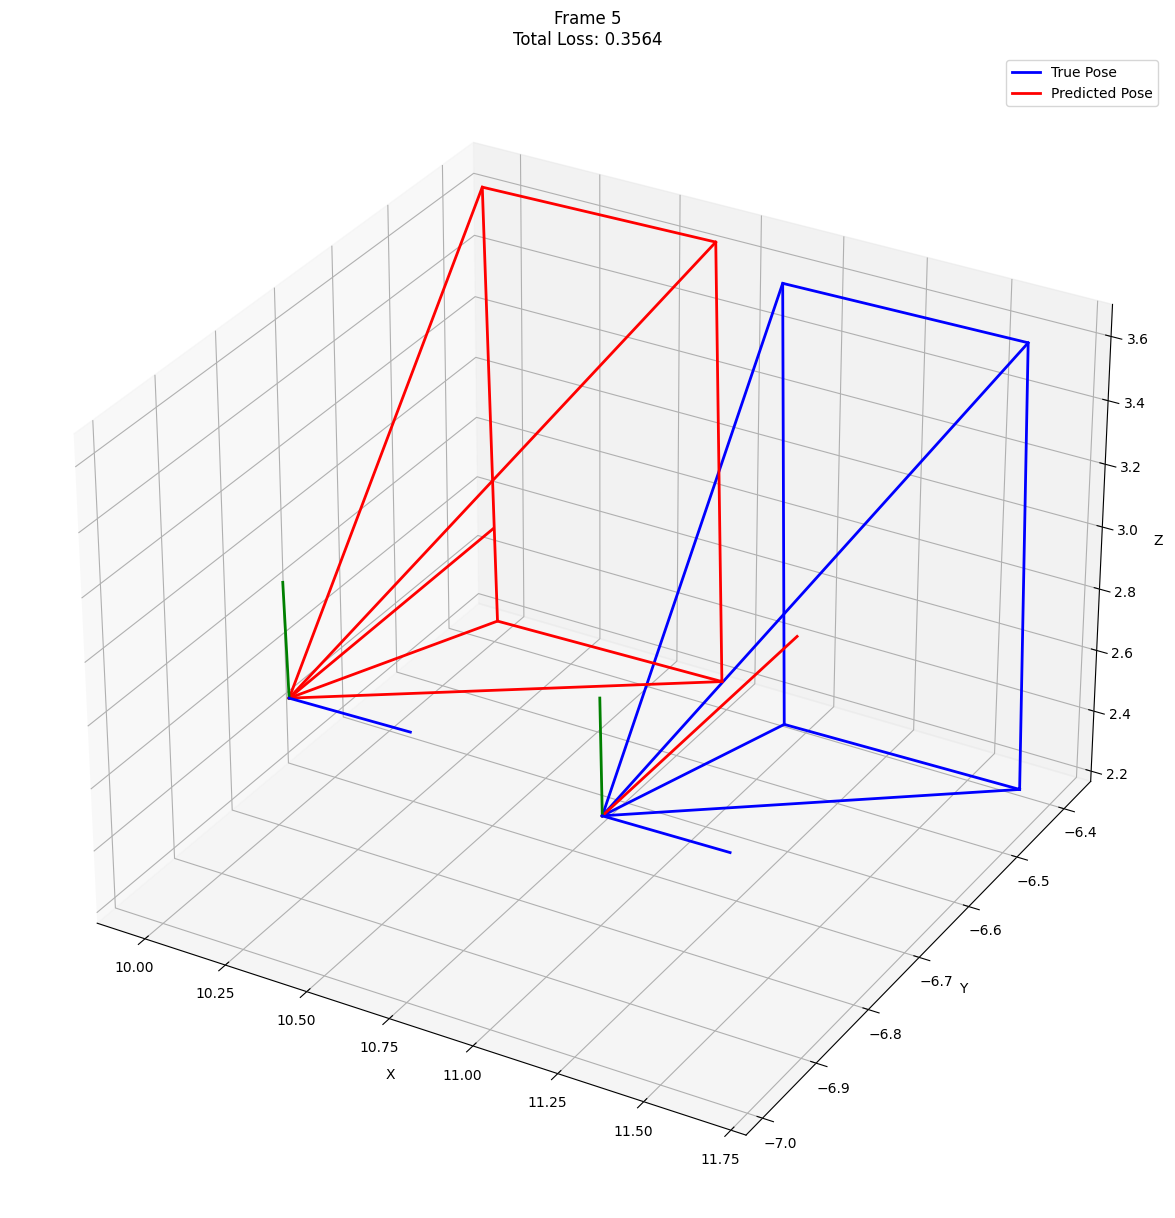

In [107]:
# Convert lists to numpy arrays for easier handling
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

# Specify the frame number to visualize
frame_number = 5

# Calculate the total loss for the specified frame using pose_loss_fn3
y_true = torch.tensor(true_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
y_pred = torch.tensor(predicted_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
total_loss = pose_loss_fn3(y_true, y_pred).item()

# Visualization
camScale = 3
camBodyColor = 'black'

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

rows = 240
cols = 480

def plot_single_frame(ax, true_pos, pred_pos, color_true='blue', color_pred='red'):
    R_gc_true = eul2rot(true_pos[3], true_pos[4], true_pos[5])
    p_gc_true = np.array([true_pos[0], true_pos[1], true_pos[2]])

    R_gc_pred = eul2rot(pred_pos[3], pred_pos[4], pred_pos[5])
    p_gc_pred = np.array([pred_pos[0], pred_pos[1], pred_pos[2]])

    camBody = np.zeros((3, 4))
    camBody[:, 0] = camScale * np.array([(rows/2), (rows-50), -(cols/2)]) / 1000
    camBody[:, 1] = camScale * np.array([-(rows/2), (rows-50), -(cols/2)]) / 1000
    camBody[:, 2] = camScale * np.array([-(rows/2), (rows-50), (cols/2)]) / 1000
    camBody[:, 3] = camScale * np.array([(rows/2), (rows-50), (cols/2)]) / 1000

    camFrame = camScale * ((rows/2) / 1000) * np.eye(3)
    Rz90 = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])
    Rx90 = np.array([
        [1, 0, 0],
        [0, 0, -1],
        [0, 1, 0]
    ])
    camFrame = Rz90.dot(Rx90).dot(camFrame)

    camBody_true = R_gc_true.dot(camBody) + p_gc_true[:, np.newaxis]
    camFrame_true = R_gc_true.dot(camFrame) + p_gc_true[:, np.newaxis]

    camBody_pred = R_gc_pred.dot(camBody) + p_gc_pred[:, np.newaxis]
    camFrame_pred = R_gc_pred.dot(camFrame) + p_gc_pred[:, np.newaxis]

    # Draw true camera body
    for i in range(4):
        ax.plot([camBody_true[0, i], p_gc_true[0]], [camBody_true[1, i], p_gc_true[1]], [camBody_true[2, i], p_gc_true[2]], color=color_true, linewidth=2, label='True Pose' if i == 0 else "")
    ax.plot(camBody_true[0, [0, 1, 2, 3, 0]], camBody_true[1, [0, 1, 2, 3, 0]], camBody_true[2, [0, 1, 2, 3, 0]], color=color_true, linewidth=2)

    # Draw true camera frame (RGB axis)
    colors = ['r', 'g', 'b']
    for i in range(3):
        ax.plot([camFrame_true[0, i], p_gc_true[0]], [camFrame_true[1, i], p_gc_true[1]], [camFrame_true[2, i], p_gc_true[2]], color=colors[i], linewidth=2)

    # Draw predicted camera body
    for i in range(4):
        ax.plot([camBody_pred[0, i], p_gc_pred[0]], [camBody_pred[1, i], p_gc_pred[1]], [camBody_pred[2, i], p_gc_pred[2]], color=color_pred, linewidth=2, label='Predicted Pose' if i == 0 else "")
    ax.plot(camBody_pred[0, [0, 1, 2, 3, 0]], camBody_pred[1, [0, 1, 2, 3, 0]], camBody_pred[2, [0, 1, 2, 3, 0]], color=color_pred, linewidth=2)

    # Draw predicted camera frame (RGB axis)
    for i in range(3):
        ax.plot([camFrame_pred[0, i], p_gc_pred[0]], [camFrame_pred[1, i], p_gc_pred[1]], [camFrame_pred[2, i], p_gc_pred[2]], color=colors[i], linewidth=2)

# Plot the single frame
plot_single_frame(ax, true_positions[frame_number], predicted_positions[frame_number])

ax.set_aspect('auto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the loss
plt.title(f'Frame {frame_number}\nTotal Loss: {total_loss:.4f}')
plt.legend()
plt.show()

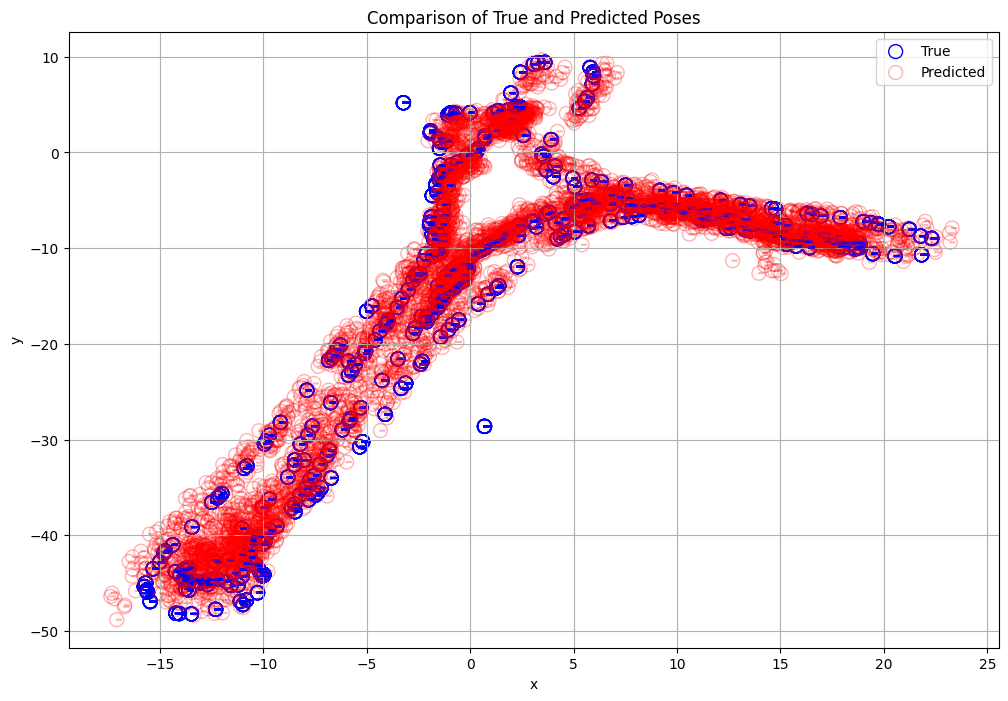

In [108]:
plot_pose_comparison(true_positions, predicted_positions)

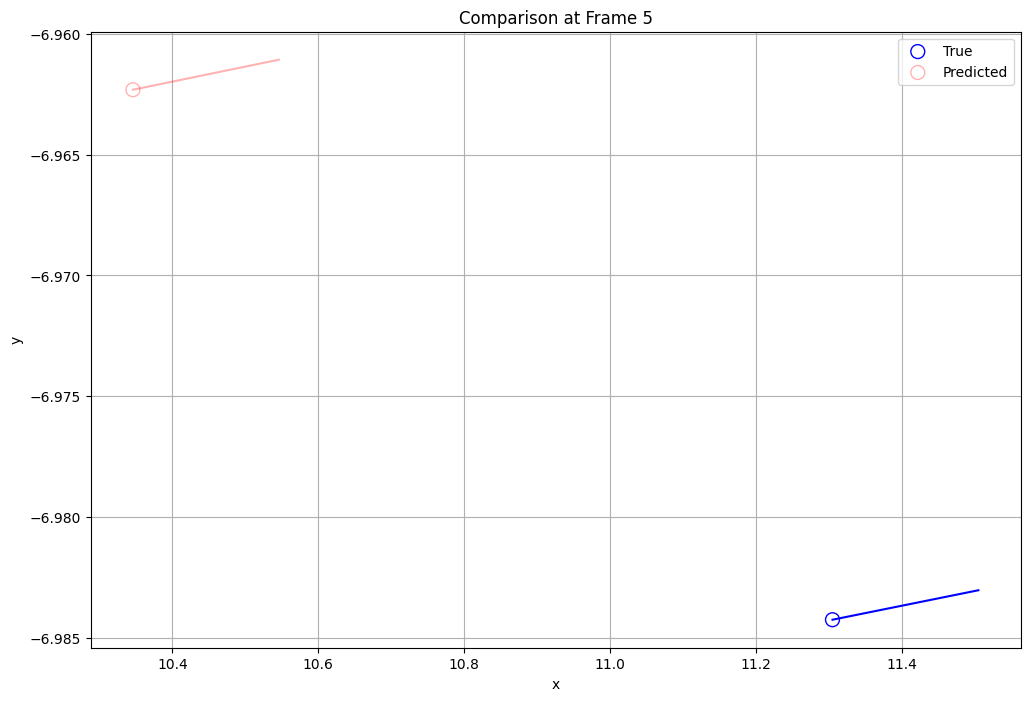

In [109]:
# 특정 프레임 비교 시각화
plot_pose_comparison(true_positions, predicted_positions, frame_number=5)

## Quaternian loss - flexible beta

In [110]:
class DynamicBetaAdjustment:
    def __init__(self, initial_beta=1.0, min_beta=0.1, max_beta=2.0, beta_decay_factor=0.95):
        self.beta = initial_beta
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.beta_decay_factor = beta_decay_factor

    def on_epoch_end(self, epoch, logs):
        self.beta = max(self.min_beta, self.beta * self.beta_decay_factor)
        self.beta = min(self.max_beta, self.beta)
        print(f"Epoch {epoch+1}: Adjusted beta value to {self.beta}")

class PoseNetLoss4(nn.Module):
    def __init__(self, beta_value=0.5):
        super(PoseNetLoss4, self).__init__()
        self.beta_value = beta_value

    def forward(self, y_true, y_pred):
        position_loss = compute_position_loss2(y_true, y_pred)
        quaternion_loss = compute_quaternion_loss(y_true, y_pred)
        combined_loss = position_loss + self.beta_value * quaternion_loss
        return combined_loss

In [111]:
pose_loss_fn4 = PoseNetLoss4(beta_value=0.5)

In [112]:
dynamic_beta_adjustment = DynamicBetaAdjustment(initial_beta=0.5, min_beta=0.1, max_beta=1.0, beta_decay_factor=0.95)

In [113]:
true_positions_list = []
predicted_positions_list = []

In [114]:
for epoch in range(num_epochs):
    base_model.train()
    train_position_loss = 0
    train_quaternion_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)

        # Calculate losses
        position_loss = compute_position_loss2(labels, outputs)
        quaternion_loss = compute_quaternion_loss(labels, outputs)
        combined_loss = pose_loss_fn4(labels, outputs)
        combined_loss.backward()
        optimizer.step()

        train_position_loss += position_loss.item()
        train_quaternion_loss += quaternion_loss.item()

    train_position_loss /= len(train_loader)
    train_quaternion_loss /= len(train_loader)

    base_model.eval()
    val_position_loss = 0
    val_quaternion_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = base_model(images)

            # Store true and predicted values for visualization
            true_positions_list.append(labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

            val_position_loss += compute_position_loss2(labels, outputs).item()
            val_quaternion_loss += compute_quaternion_loss(labels, outputs).item()

    val_position_loss /= len(val_loader)
    val_quaternion_loss /= len(val_loader)

    logs = {
        'train_position_loss': train_position_loss,
        'train_quaternion_loss': train_quaternion_loss,
        'val_position_loss': val_position_loss,
        'val_quaternion_loss': val_quaternion_loss
    }
    loss_history.on_epoch_end(epoch, logs)
    dynamic_beta_adjustment.on_epoch_end(epoch, logs)
    pose_loss_fn4.beta_value = dynamic_beta_adjustment.beta

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Position Loss: {train_position_loss}, Train Quaternion Loss: {train_quaternion_loss}, Val Position Loss: {val_position_loss}, Val Quaternion Loss: {val_quaternion_loss}")
# Measure and print the metrics
measure_metrics(base_model, input_size)

Epoch 1: Adjusted beta value to 0.475
Epoch 1/10, Train Position Loss: 0.5839655700386787, Train Quaternion Loss: 0.2768090957281541, Val Position Loss: 0.856606678051107, Val Quaternion Loss: 0.2618669885046342
Epoch 2: Adjusted beta value to 0.45125
Epoch 2/10, Train Position Loss: 1.1129610246541548, Train Quaternion Loss: 0.28815011619305125, Val Position Loss: 1.2224442459204619, Val Quaternion Loss: 0.23808426278478959
Epoch 3: Adjusted beta value to 0.42868749999999994
Epoch 3/10, Train Position Loss: 0.6734650420899294, Train Quaternion Loss: 0.29451329337090865, Val Position Loss: 2.2319145956460167, Val Quaternion Loss: 0.2178865513380836
Epoch 4: Adjusted beta value to 0.40725312499999994
Epoch 4/10, Train Position Loss: 0.6968129970589463, Train Quaternion Loss: 0.2624896488019398, Val Position Loss: 2.3958598305197323, Val Quaternion Loss: 0.2891267634489957
Epoch 5: Adjusted beta value to 0.38689046874999994
Epoch 5/10, Train Position Loss: 0.7539952908243451, Train Quate

### 카메라 시각화(flexible beta)

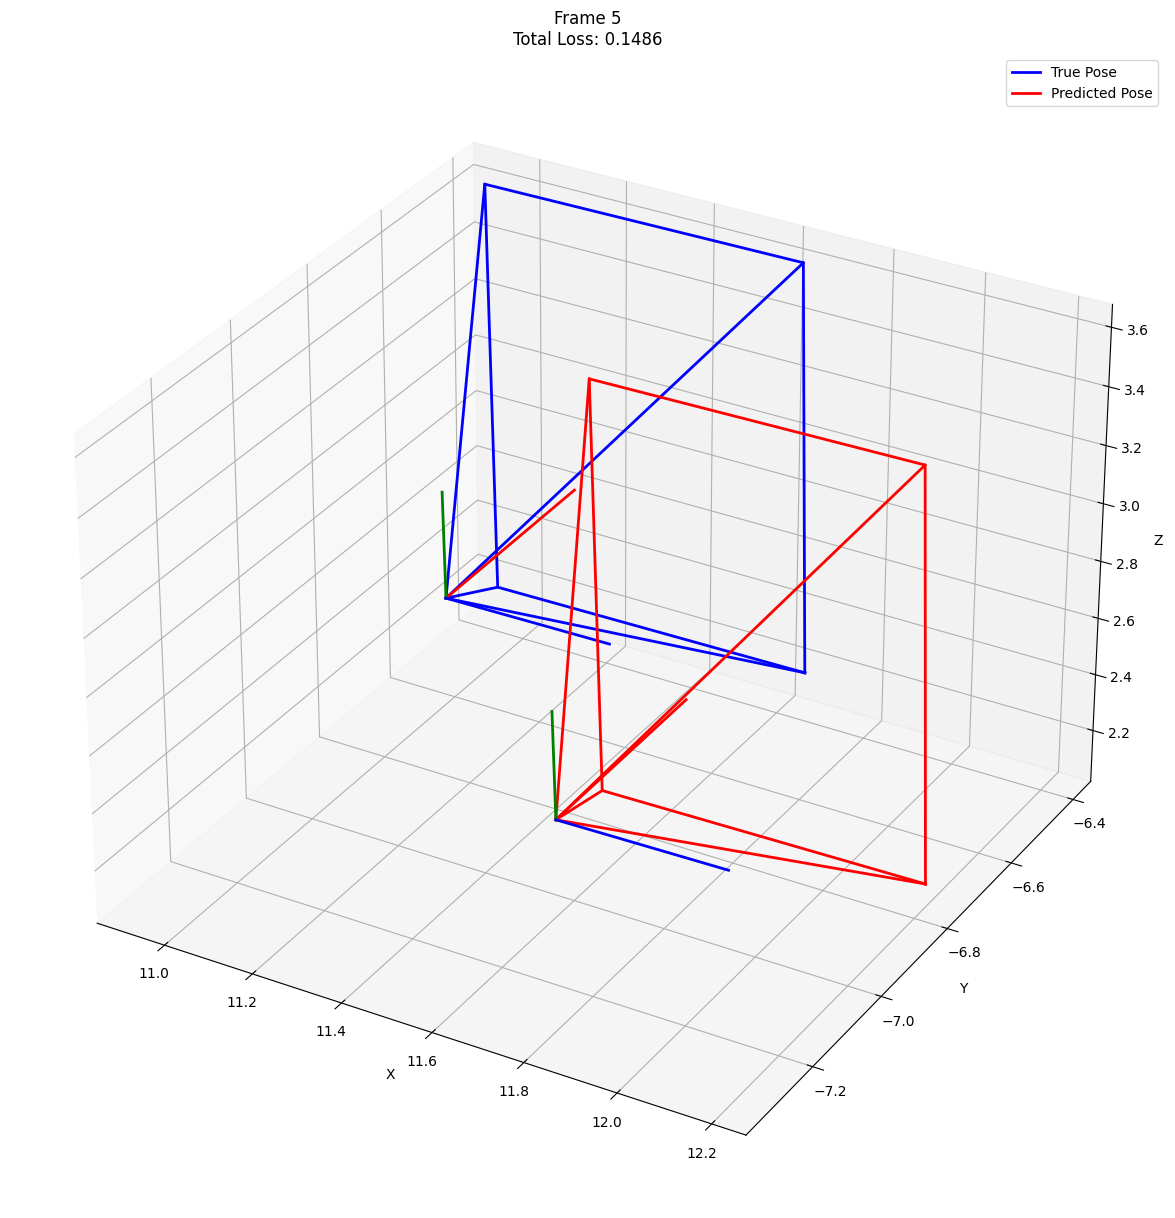

In [115]:
# Convert lists to numpy arrays for easier handling
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

# Specify the frame number to visualize
frame_number = 5

# Calculate the total loss for the specified frame using pose_loss_fn4
y_true = torch.tensor(true_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
y_pred = torch.tensor(predicted_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
total_loss = pose_loss_fn4(y_true, y_pred).item()

# Visualization
camScale = 3
camBodyColor = 'black'

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

rows = 240
cols = 480
# Plot the single frame
plot_single_frame(ax, true_positions[frame_number], predicted_positions[frame_number])

ax.set_aspect('auto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the loss
plt.title(f'Frame {frame_number}\nTotal Loss: {total_loss:.4f}')
plt.legend()
plt.show()


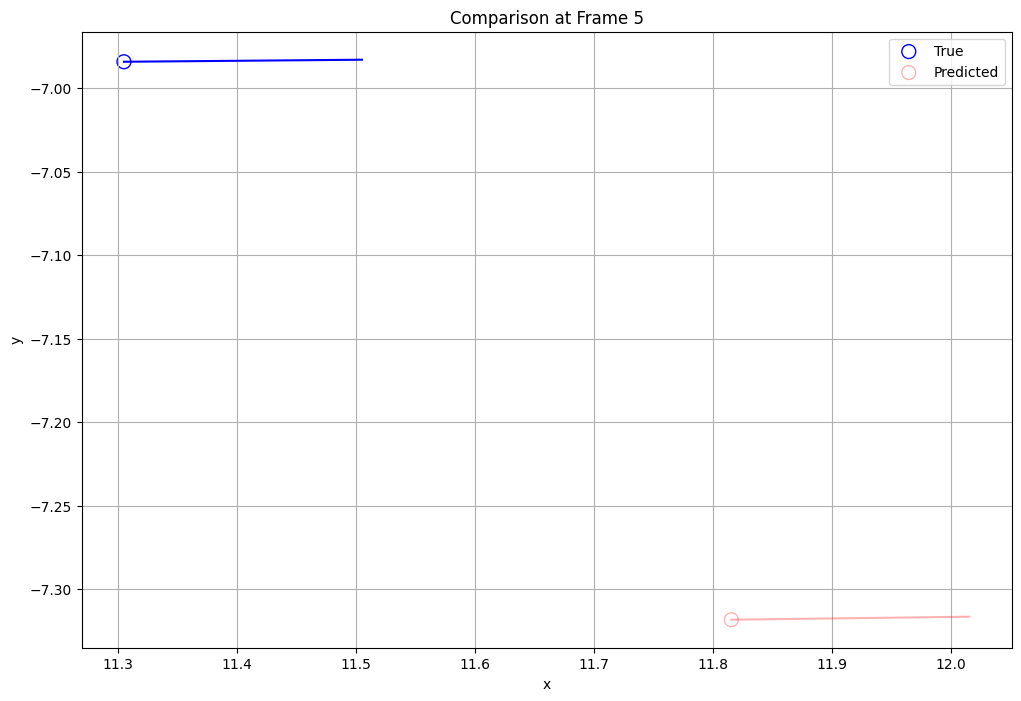

In [116]:
# 특정 프레임 비교 시각화
plot_pose_comparison(true_positions, predicted_positions, frame_number=5)

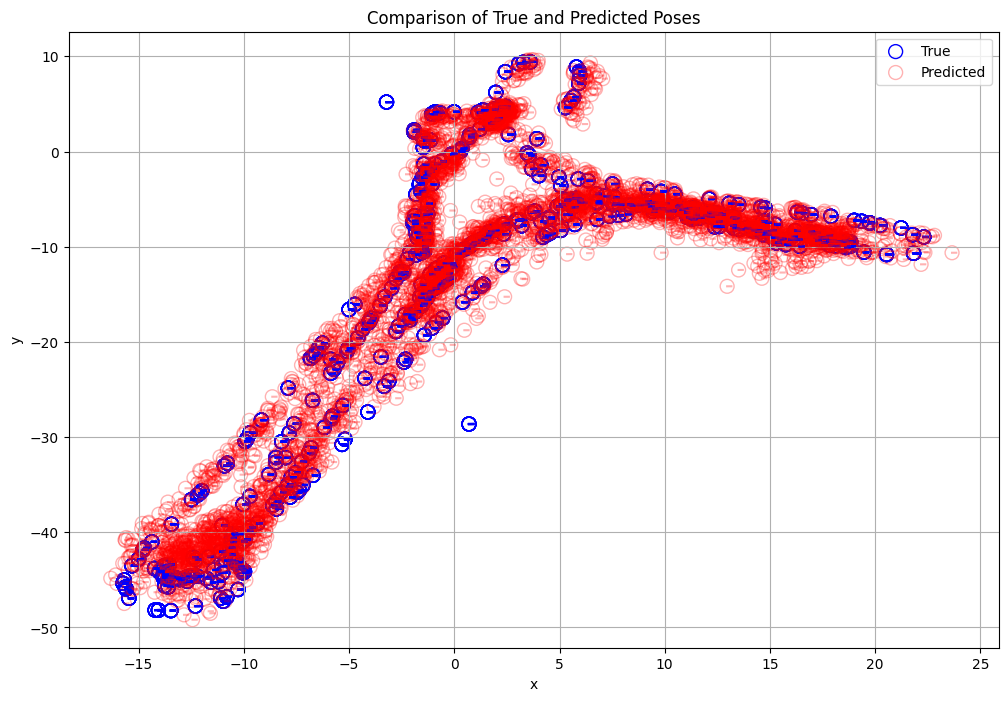

In [117]:
plot_pose_comparison(true_positions, predicted_positions)

# 모델


(1) ResNet50 PoseNet

In [118]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [119]:
base_model = ResNet50Model(num_classes=7).to(device)

In [120]:
patience = 5
best_loss = float('inf')
epochs_no_improve = 0
criterion=PoseNetLoss4()
true_positions_list = []
predicted_positions_list = []

In [121]:
# Early stopping loop
stop_training = False
actual_epochs = 0  # To keep track of the actual number of epochs run
for epoch in range(num_epochs):
    if stop_training:
        break

    base_model.train()
    train_position_loss = 0
    train_quaternion_loss = 0
    for images, labels in train_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)  # Move images to GPU
        labels = labels.to(device)  # Move labels to GPU

        optimizer.zero_grad()
        outputs = base_model(images)

        # Calculate losses
        position_loss = compute_position_loss2(labels, outputs)
        quaternion_loss = compute_quaternion_loss(labels, outputs)
        combined_loss = pose_loss_fn4(labels, outputs)
        combined_loss.backward()
        optimizer.step()

        train_position_loss += position_loss.item()
        train_quaternion_loss += quaternion_loss.item()

    train_position_loss /= len(train_loader)
    train_quaternion_loss /= len(train_loader)

    base_model.eval()
    val_position_loss = 0
    val_quaternion_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move images and labels to the same device as the model
            images = images.to(device)  # Move images to GPU
            labels = labels.to(device)  # Move labels to GPU

            outputs = base_model(images)

            # Store true and predicted values for visualization
            true_positions_list.append(labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

            val_position_loss += compute_position_loss2(labels, outputs).item()
            val_quaternion_loss += compute_quaternion_loss(labels, outputs).item()

    val_position_loss /= len(val_loader)
    val_quaternion_loss /= len(val_loader)

    logs = {
        'train_position_loss': train_position_loss,
        'train_quaternion_loss': train_quaternion_loss,
        'val_position_loss': val_position_loss,
        'val_quaternion_loss': val_quaternion_loss
    }
    loss_history.on_epoch_end(epoch, logs)
    dynamic_beta_adjustment.on_epoch_end(epoch, logs)
    pose_loss_fn4.beta_value = dynamic_beta_adjustment.beta

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Position Loss: {train_position_loss}, Train Quaternion Loss: {train_quaternion_loss}, Val Position Loss: {val_position_loss}, Val Quaternion Loss: {val_quaternion_loss}")


    # Early stopping
    combined_val_loss = val_position_loss + val_quaternion_loss
    if combined_val_loss < best_loss:
        best_loss = combined_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        stop_training = True

    actual_epochs += 1  # Update the actual number of epochs run
# Measure and print the metrics
measure_metrics(base_model, input_size)

Epoch 1: Adjusted beta value to 0.2844000461382298
Epoch 1/10, Train Position Loss: 158.52366856166296, Train Quaternion Loss: 1.581513271039846, Val Position Loss: 176.9752915326287, Val Quaternion Loss: 1.5713161510579727
Epoch 2: Adjusted beta value to 0.2701800438313183
Epoch 2/10, Train Position Loss: 158.02604114766024, Train Quaternion Loss: 1.5782829815027666, Val Position Loss: 177.54212076523726, Val Quaternion Loss: 1.568861442453721
Epoch 3: Adjusted beta value to 0.25667104163975235
Epoch 3/10, Train Position Loss: 157.72372545514787, Train Quaternion Loss: 1.5806631774318463, Val Position Loss: 177.34596207562615, Val Quaternion Loss: 1.5694824667537914
Epoch 4: Adjusted beta value to 0.24383748955776471
Epoch 4/10, Train Position Loss: 158.50732873410595, Train Quaternion Loss: 1.5791179939192168, Val Position Loss: 177.31213311588064, Val Quaternion Loss: 1.5716186200871187
Epoch 5: Adjusted beta value to 0.23164561507987647
Epoch 5/10, Train Position Loss: 159.44330581

In [122]:
torch.save(base_model.state_dict(), '/content/drive/MyDrive/model/resnet_10.pth')

In [123]:
plot_metrics(loss_history, actual_epochs)

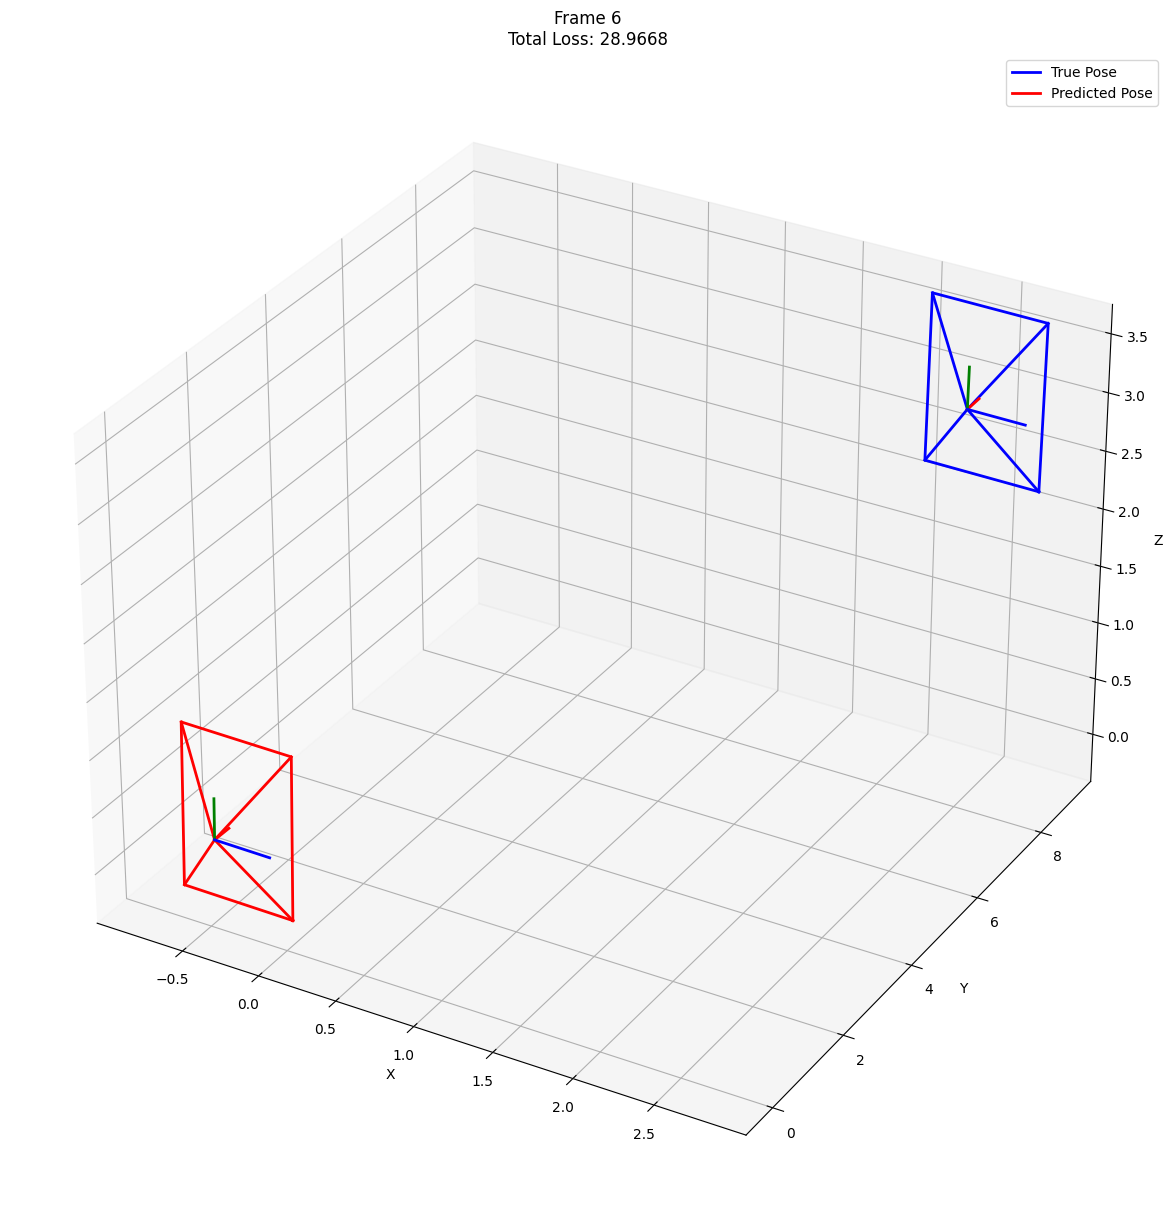

In [124]:
# Convert lists to numpy arrays for easier handling
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

# Specify the frame number to visualize
frame_number = 6

# Calculate the total loss for the specified frame using pose_loss_fn4
y_true = torch.tensor(true_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
y_pred = torch.tensor(predicted_positions[frame_number]).float().unsqueeze(0)  # Add batch dimension
total_loss = pose_loss_fn4(y_true, y_pred).item()

# Visualization
camScale = 3
camBodyColor = 'black'

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

rows = 240
cols = 480
# Plot the single frame
plot_single_frame(ax, true_positions[frame_number], predicted_positions[frame_number])

ax.set_aspect('auto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the loss
plt.title(f'Frame {frame_number}\nTotal Loss: {total_loss:.4f}')
plt.legend()
plt.show()

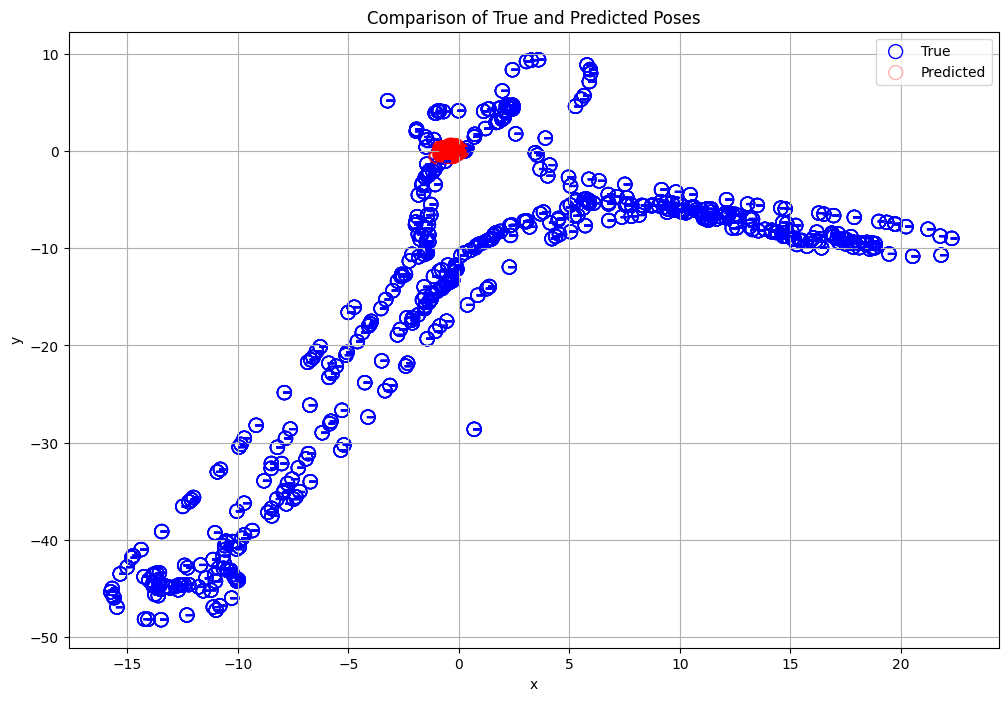

In [125]:
plot_pose_comparison(true_positions, predicted_positions)

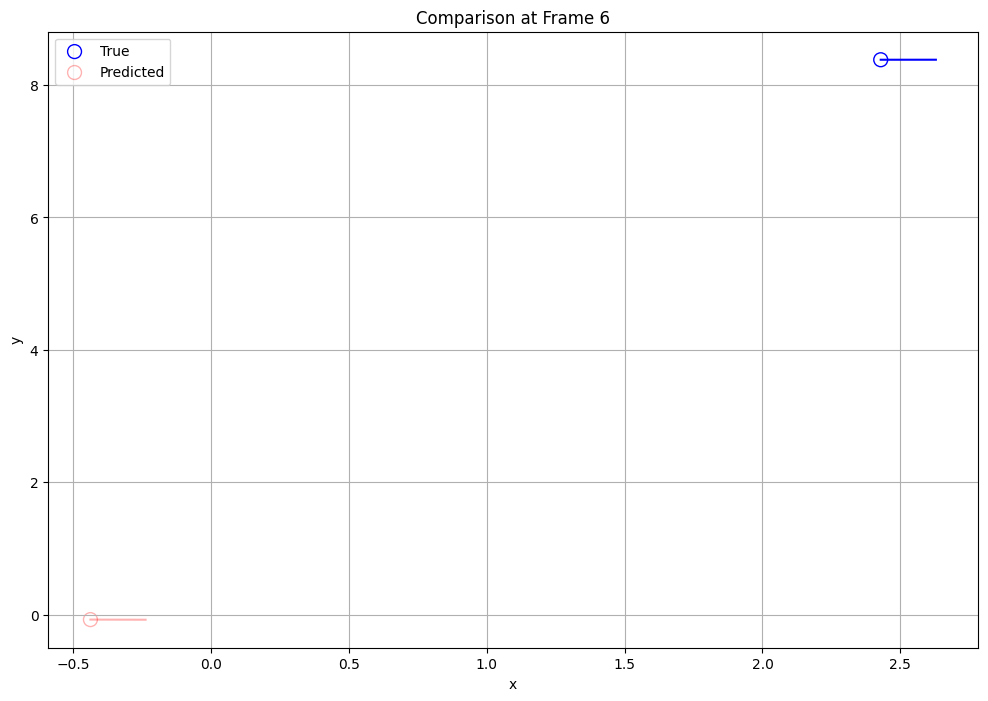

In [126]:
plot_pose_comparison(true_positions, predicted_positions, frame_number=6)

In [127]:
# 모델 평가
test_loss, test_position_loss, test_quaternion_loss, true_positions, predicted_positions = evaluate_model(base_model, test_loader, criterion)

Test Loss: 182.2214, Test Position Loss: 181.4416, Test Quaternion Loss: 1.5597
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 4032224128.0
Parameters: 23522375.0
Latency: 0.012470 seconds


In [128]:
def visualize_predictions(model, data_loader, num_batches=5):
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predictions = outputs.cpu().numpy()
            ground_truth = labels.cpu().numpy()

            all_predictions.append(predictions)
            all_ground_truths.append(ground_truth)

    # 배치 개수별로 시각화
    fig, axes = plt.subplots(num_batches, 1, figsize=(10, 5 * num_batches))

    if num_batches == 1:
        axes = [axes]

    for i in range(num_batches):
        predictions = all_predictions[i]
        ground_truth = all_ground_truths[i]

        # 위치 예측 결과 시각화 (x, y 좌표만)
        axes[i].scatter(ground_truth[:, 0], ground_truth[:, 1], label='Label')
        axes[i].scatter(predictions[:, 0], predictions[:, 1], label='Predictions')
        axes[i].legend()
        axes[i].set_title(f'Test Data Position Predictions')
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

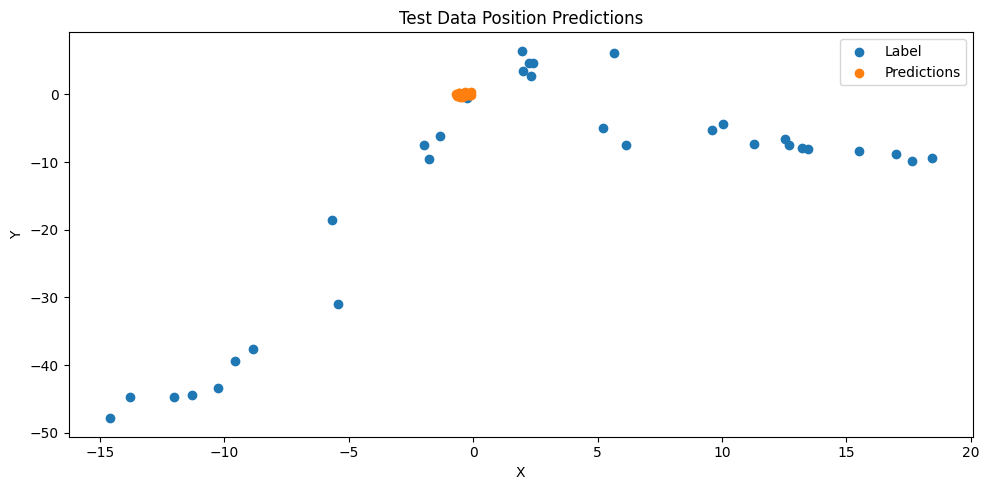

In [129]:
visualize_predictions(base_model, test_loader, num_batches = 1)

(2) TransPoseNet(only transformer)

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np

# Custom positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Custom transformer block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.Tanh(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, inputs, mask=None):
        attn_output, _ = self.att(inputs, inputs, inputs, attn_mask=mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Custom transformer encoder
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.enc_layers = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(rate)

    def forward(self, inputs, mask=None):
        x = self.pos_encoding(inputs)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x, mask)
        return x

# Custom backbone based on ResNet50
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        self.base_model = models.resnet50(weights='IMAGENET1K_V1')
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_channels = 2048  # Output channels of ResNet50's last layer

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        return x

# Custom model
class TransformerPoseNet(nn.Module):
    def __init__(self, backbone, transformer_dim=256, num_heads=4, num_layers=6):
        super(TransformerPoseNet, self).__init__()
        self.backbone = backbone

        self.position_dense = nn.Linear(backbone.output_channels, transformer_dim)
        self.orientation_dense = nn.Linear(backbone.output_channels, transformer_dim)

        self.position_transformer = TransformerEncoder(num_layers, transformer_dim, num_heads, transformer_dim*4)
        self.orientation_transformer = TransformerEncoder(num_layers, transformer_dim, num_heads, transformer_dim*4)
        self.fc_position = nn.Linear(transformer_dim, 3)  # Output x, y, z
        self.fc_orientation = nn.Linear(transformer_dim, 4)  # Output w, x, y, z(different the positions' x,y,z)

    def forward(self, x):
        x = self.backbone(x)#Backbone output shape: torch.Size([32, 2048])

        position_features = torch.tanh(self.position_dense(x))
        orientation_features = torch.tanh(self.orientation_dense(x))

        position_features = position_features.unsqueeze(1)
        orientation_features = orientation_features.unsqueeze(1)

        position_output = self.position_transformer(position_features)
        orientation_output = self.orientation_transformer(orientation_features)

        position_output = position_output.squeeze(1)
        orientation_output = orientation_output.squeeze(1)

        position = self.fc_position(position_output)
        orientation = self.fc_orientation(orientation_output)

        return torch.cat([position, orientation], dim=-1)

In [131]:
# Instantiate the model
custom_backbone = CustomBackbone()
model = TransformerPoseNet(backbone = custom_backbone)
model = model.to(device)

In [132]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_losses = []
val_losses = []
patience = 5
best_loss = float('inf')
epochs_no_improve = 0

# Assuming loss_history is an instance of LossHistory class
loss_history = LossHistory()
# Updated training loop with loss history tracking
num_epochs = 10

true_positions_list = []
predicted_positions_list = []

In [133]:
# Early stopping loop
stop_training = False
actual_epochs = 0  # To keep track of the actual number of epochs run
for epoch in range(num_epochs):
    if stop_training:
        break

    model.train()
    train_position_loss = 0
    train_quaternion_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate losses
        position_loss = compute_position_loss2(labels, outputs)
        quaternion_loss = compute_quaternion_loss(labels, outputs)
        combined_loss = pose_loss_fn4(labels, outputs)
        combined_loss.backward()
        optimizer.step()

        train_position_loss += position_loss.item()
        train_quaternion_loss += quaternion_loss.item()

    train_position_loss /= len(train_loader)
    train_quaternion_loss /= len(train_loader)

    model.eval()
    val_position_loss = 0
    val_quaternion_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = base_model(images)

            # Store true and predicted values for visualization
            true_positions_list.append(labels.cpu().numpy())
            predicted_positions_list.append(outputs.cpu().numpy())

            val_position_loss += compute_position_loss2(labels, outputs).item()
            val_quaternion_loss += compute_quaternion_loss(labels, outputs).item()

    val_position_loss /= len(val_loader)
    val_quaternion_loss /= len(val_loader)

    logs = {
        'train_position_loss': train_position_loss,
        'train_quaternion_loss': train_quaternion_loss,
        'val_position_loss': val_position_loss,
        'val_quaternion_loss': val_quaternion_loss
    }
    loss_history.on_epoch_end(epoch, logs)
    dynamic_beta_adjustment.on_epoch_end(epoch, logs)
    pose_loss_fn4.beta_value = dynamic_beta_adjustment.beta

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Position Loss: {train_position_loss}, Train Quaternion Loss: {train_quaternion_loss}, Val Position Loss: {val_position_loss}, Val Quaternion Loss: {val_quaternion_loss}")

    # Early stopping
    combined_val_loss = val_position_loss + val_quaternion_loss
    if combined_val_loss < best_loss:
        best_loss = combined_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        stop_training = True

    actual_epochs += 1  # Update the actual number of epochs run
# Measure and print the metrics
measure_metrics(base_model, input_size)

Epoch 1: Adjusted beta value to 0.20906016760958848
Epoch 1/10, Train Position Loss: 89.25644668267698, Train Quaternion Loss: 0.7661617714531568, Val Position Loss: 177.33538773480583, Val Quaternion Loss: 1.5662435573690079
Epoch 2: Adjusted beta value to 0.19860715922910904
Epoch 2/10, Train Position Loss: 68.17107846785565, Train Quaternion Loss: 0.7105586078702187, Val Position Loss: 177.33538773480583, Val Quaternion Loss: 1.5662435573690079
Epoch 3: Adjusted beta value to 0.18867680126765357
Epoch 3/10, Train Position Loss: 60.98072188241141, Train Quaternion Loss: 0.6670220159754461, Val Position Loss: 177.33538773480583, Val Quaternion Loss: 1.5662435573690079
Epoch 4: Adjusted beta value to 0.17924296120427088
Epoch 4/10, Train Position Loss: 55.27181500804667, Train Quaternion Loss: 0.6370905193747306, Val Position Loss: 177.33538773480583, Val Quaternion Loss: 1.5662435573690079
Epoch 5: Adjusted beta value to 0.17028081314405732
Epoch 5/10, Train Position Loss: 49.80455061

In [ ]:
#torch.save(model.state_dict(), 'transformer_10.pth')

In [134]:
# Plot the training and validation metrics
plot_metrics(loss_history, actual_epochs)

In [135]:
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

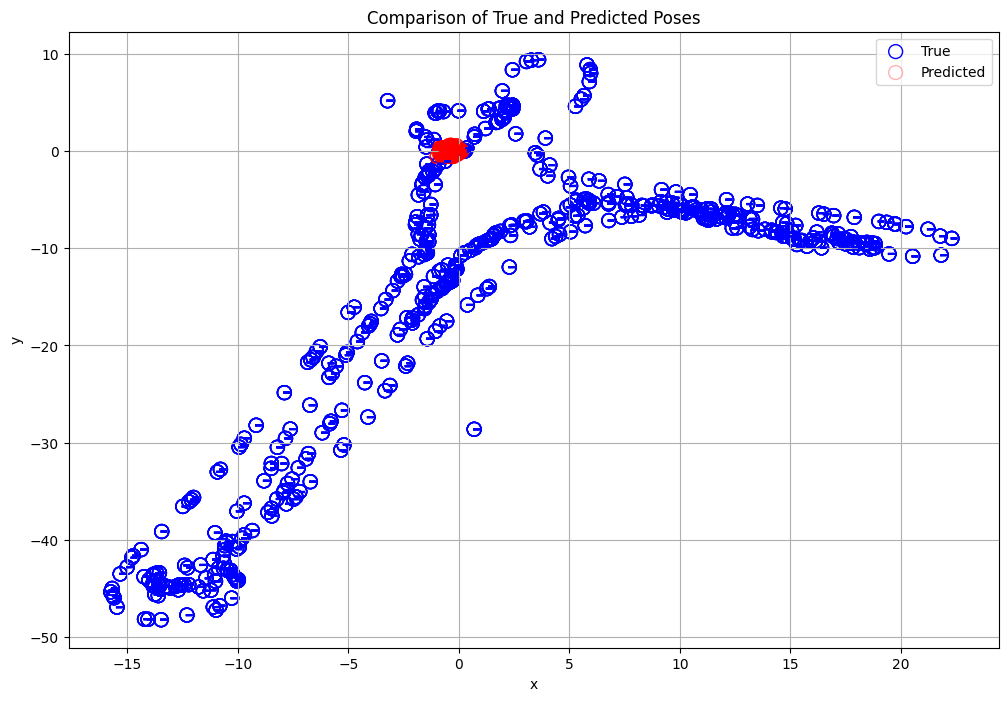

In [136]:
plot_pose_comparison(true_positions, predicted_positions)

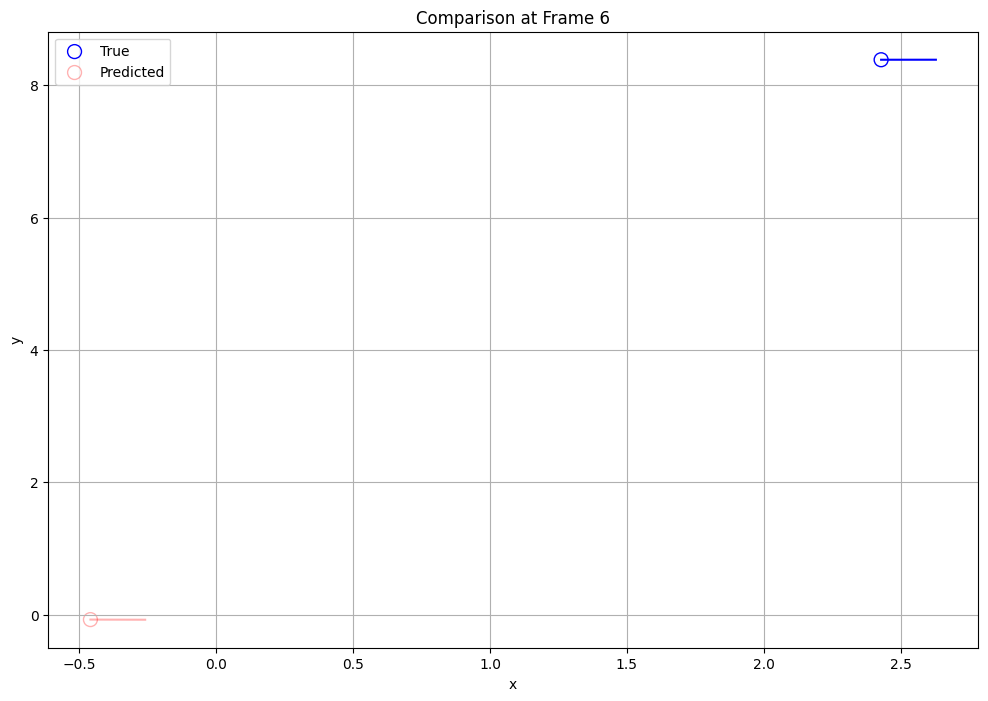

In [137]:
plot_pose_comparison(true_positions, predicted_positions, frame_number=6)

In [138]:
# 모델 평가
test_loss, test_position_loss, test_quaternion_loss, true_positions, predicted_positions = evaluate_model(model, test_loader, criterion)

Test Loss: 50.2885, Test Position Loss: 50.0588, Test Quaternion Loss: 0.4596
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPs: 4039576192.0
Parameters: 30878023.0
Latency: 0.014139 seconds


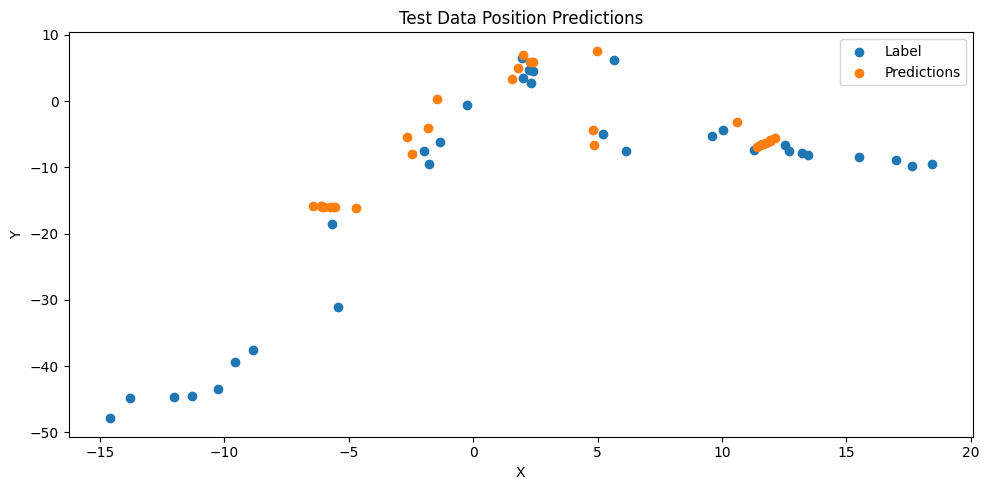

In [139]:
visualize_predictions(model, test_loader, num_batches = 1)

(3) ViT Model

In [140]:
import numpy as np
from PIL import Image

input_images = []
labels = []
input_size = (3, 224, 224)

#quarternion 변환된 데이터 사용(orientation : roll, pitch, yaw -> w, x, y, z)
#orientation은 radian
'''
# Binding images and coordinates into pairs
for image_path, coord in zip(image_file_paths, coordinates):
    # Image loading and preprocessing
    image = Image.open('/content/drive/MyDrive/image/frames_resized/' + image_path) # Resize image

    #image = np.array(image) / 255.0 # Image normalization
    image = np.divide(np.array(image), 255.0)
    # Add image and coordinates to the list
    input_images.append(image)
    labels.append(coord)

# Convert list to NumPy array
input_images = np.array(input_images)
labels = np.array(labels)
np.savez('/content/drive/MyDrive/data/data_quaternion.npz', input_images=input_images, labels=labels)
'''


loaded_data = np.load('/content/drive/MyDrive/data/data_224_quaternion.npz')
#loaded_data = np.load('/content/drive/MyDrive/24-1딥러닝/data/data_quaternion.npz')
input_images = loaded_data['input_images']
labels = loaded_data['labels']

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig

# 데이터셋 클래스 정의
class PoseDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

# PoseNet with Vision Transformer 모델 정의
class PoseNetTransformer(nn.Module):
    def __init__(self, pretrained=True):
        super(PoseNetTransformer, self).__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = ViTModel(config)
        num_ftrs = config.hidden_size

        self.fc_position = nn.Linear(num_ftrs, 3)
        self.fc_orientation = nn.Linear(num_ftrs, 4)

    def forward(self, x):
        outputs = self.vit(x).last_hidden_state
        outputs = outputs[:, 0, :]  # CLS 토큰만 사용
        position = self.fc_position(outputs)
        orientation = self.fc_orientation(outputs)
        return position, orientation

# Custom loss functions and metrics
def compute_position_loss2(y_true, y_pred):
    position_true = y_true[:, :3]
    position_pred = y_pred[0]
    return torch.mean((position_pred - position_true) ** 2)

def compute_quaternion_loss(y_true, y_pred):
    epsilon = 1e-7
    quaternion_true = y_true[:, 3:]
    quaternion_pred = y_pred[1]
    quaternion_true = quaternion_true / (torch.norm(quaternion_true, dim=1, keepdim=True) + epsilon)
    quaternion_pred = quaternion_pred / (torch.norm(quaternion_pred, dim=1, keepdim=True) + epsilon)
    return torch.mean(torch.norm(quaternion_true - quaternion_pred, dim=1))

class PoseNetLoss4(nn.Module):
    def __init__(self, beta=0.5):
        super(PoseNetLoss4, self).__init__()
        self.beta_value = beta

    def forward(self, y_true, y_pred):
        position_loss = compute_position_loss2(y_true, y_pred)
        quaternion_loss = compute_quaternion_loss(y_true, y_pred)
        combined_loss = position_loss + self.beta_value * quaternion_loss
        return combined_loss

# LossHistory 클래스 정의
class LossHistory:
    def __init__(self):
        self.train_position_losses = []
        self.train_quaternion_losses = []
        self.val_position_losses = []
        self.val_quaternion_losses = []

    def on_epoch_end(self, train_position_loss, train_quaternion_loss, val_position_loss, val_quaternion_loss):
        self.train_position_losses.append(train_position_loss)
        self.train_quaternion_losses.append(train_quaternion_loss)
        self.val_position_losses.append(val_position_loss)
        self.val_quaternion_losses.append(val_quaternion_loss)

# DynamicBetaAdjustment 클래스 정의
class DynamicBetaAdjustment:
    def __init__(self, initial_beta=1.0, min_beta=0.1, max_beta=2.0, beta_decay_factor=0.95):
        self.beta = initial_beta
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.beta_decay_factor = beta_decay_factor

    def on_epoch_end(self, epoch, logs):
        self.beta = max(self.min_beta, self.beta * self.beta_decay_factor)
        print(f"Epoch {epoch+1}: Adjusted beta value to {self.beta}")

# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered. Restoring best model from epoch with validation loss {self.best_loss:.4f}")
                model.load_state_dict(self.best_model)
                return True
        return False

# 전체 데이터를 train+val과 test로 나눕니다.
x_train_val, x_test_224, y_train_val, y_test_224 = train_test_split(input_images, labels, test_size=0.2, random_state=42)

# train+val 데이터를 다시 train과 val로 나눕니다.
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# 결과적으로 전체 데이터의 60%가 train, 20%가 val, 20%가 test로 나뉩니다.

# 데이터 전처리
data_transforms = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 데이터로더 초기화
train_dataset = PoseDataset(x_train, y_train, transform=data_transforms)
val_dataset = PoseDataset(x_val, y_val, transform=data_transforms)
test_224_dataset = PoseDataset(x_test_224, y_test_224, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_224_loader = DataLoader(test_224_dataset, batch_size=32, shuffle=False)

# 모델 초기화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PoseNetTransformer().to(device)
criterion = PoseNetLoss4(beta=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=3, min_lr=1e-6)

early_stopping = EarlyStopping(patience=10, min_delta=0.01)
beta_adjustment = DynamicBetaAdjustment(initial_beta=0.5)
loss_history_vit_10 = LossHistory()
true_positions_list = []
predicted_positions_list = []

# 훈련 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                early_stopping, beta_adjustment, loss_history_vit_10, num_epochs=10):
  # For storing true and predicted values
    true_positions_list = []
    predicted_positions_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_position_loss = 0.0
        train_quaternion_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(labels, outputs)

            position_loss = compute_position_loss2(labels, outputs)
            quaternion_loss = compute_quaternion_loss(labels, outputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_position_loss += position_loss.item() * inputs.size(0)
            train_quaternion_loss += quaternion_loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_position_loss /= len(train_loader.dataset)
        train_quaternion_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Position Loss: {train_position_loss:.4f}, Quaternion Loss: {train_quaternion_loss:.4f}')

        # Validation step
        model.eval()
        val_loss = 0.0
        val_position_loss = 0.0
        val_quaternion_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_labels, val_outputs).item() * val_inputs.size(0)
                val_position_loss += compute_position_loss2(val_labels, val_outputs).item() * val_inputs.size(0)
                val_quaternion_loss += compute_quaternion_loss(val_labels, val_outputs).item() * val_inputs.size(0)

                #true_positions_list.append(val_labels[:, :3].cpu().numpy()) # Extract positions and move to CPU
                true_positions_list.append(val_labels[:, :3].cpu().numpy())
                predicted_positions_list.append(val_outputs[0][:, :3].cpu().numpy()) # Extract predicted positions and move to CPU


        val_loss = val_loss / len(val_loader.dataset)
        val_position_loss = val_position_loss / len(val_loader.dataset)
        val_quaternion_loss = val_quaternion_loss / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Position Loss: {val_position_loss:.4f}, Validation Quaternion Loss: {val_quaternion_loss:.4f}')

        # 손실 기록
        loss_history_vit_10.on_epoch_end(train_position_loss, train_quaternion_loss, val_position_loss, val_quaternion_loss)

        # Learning rate adjustment
        scheduler.step(val_loss)

        # Early stopping check
        if early_stopping(val_loss, model):
            break

        # Beta 값 동적 조정
        beta_adjustment.on_epoch_end(epoch, None)
        criterion.beta_value = beta_adjustment.beta
    measure_metrics(model, input_size)
    return model, predicted_positions_list, true_positions_list

# 모델 훈련
model, predicted_positions_list, true_positions_list = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                    early_stopping, beta_adjustment, loss_history_vit_10, num_epochs=10)


# 모델 저장
#torch.save(model.state_dict(), '/content/drive/MyDrive/model/posenet_transformer_vit_10.pth')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Epoch 1/10, Loss: 74.8218, Position Loss: 74.4211, Quaternion Loss: 0.8013
Epoch 1/10, Validation Loss: 70.5515, Validation Position Loss: 70.1720, Validation Quaternion Loss: 0.7591
Epoch 1: Adjusted beta value to 0.475
Epoch 2/10, Loss: 59.7866, Position Loss: 59.4395, Quaternion Loss: 0.7307
Epoch 2/10, Validation Loss: 67.2197, Validation Position Loss: 66.8772, Validation Quaternion Loss: 0.7211
Epoch 2: Adjusted beta value to 0.45125
Epoch 3/10, Loss: 53.0913, Position Loss: 52.7643, Quaternion Loss: 0.7246
Epoch 3/10, Validation Loss: 57.8173, Validation Position Loss: 57.4938, Validation Quaternion Loss: 0.7168
Epoch 3: Adjusted beta value to 0.42868749999999994
Epoch 4/10, Loss: 44.3415, Position Loss: 44.0362, Quaternion Loss: 0.7121
Epoch 4/10, Validation Loss: 46.9494, Validation Position Loss: 46.6440, Validation Quaternion Loss: 0.7124
Epoch 4: Adjusted beta value to 0.40725312499999994
Epoch 5/10, Loss: 43.3976, Position Loss: 43.1122, Quaternion Loss: 0.7009
Epoch 5/10,

In [142]:
#loss_visualization_function

import matplotlib.pyplot as plt

def plot_training_metrics_AUE(history):
    epochs = list(range(len(history.train_position_losses)))

    # Create subplots with 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training position loss
    axs[0, 0].plot(epochs, history.train_position_losses, label='Train Position Loss')
    axs[0, 0].set_title('Training Position Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot training quaternion loss
    axs[0, 1].plot(epochs, history.train_quaternion_losses, label='Train Quaternion Loss')
    axs[0, 1].set_title('Training Quaternion Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Plot validation position loss
    axs[1, 0].plot(epochs, history.val_position_losses, label='Validation Position Loss')
    axs[1, 0].set_title('Validation Position Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Plot validation quaternion loss
    axs[1, 1].plot(epochs, history.val_quaternion_losses, label='Validation Quaternion Loss')
    axs[1, 1].set_title('Validation Quaternion Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

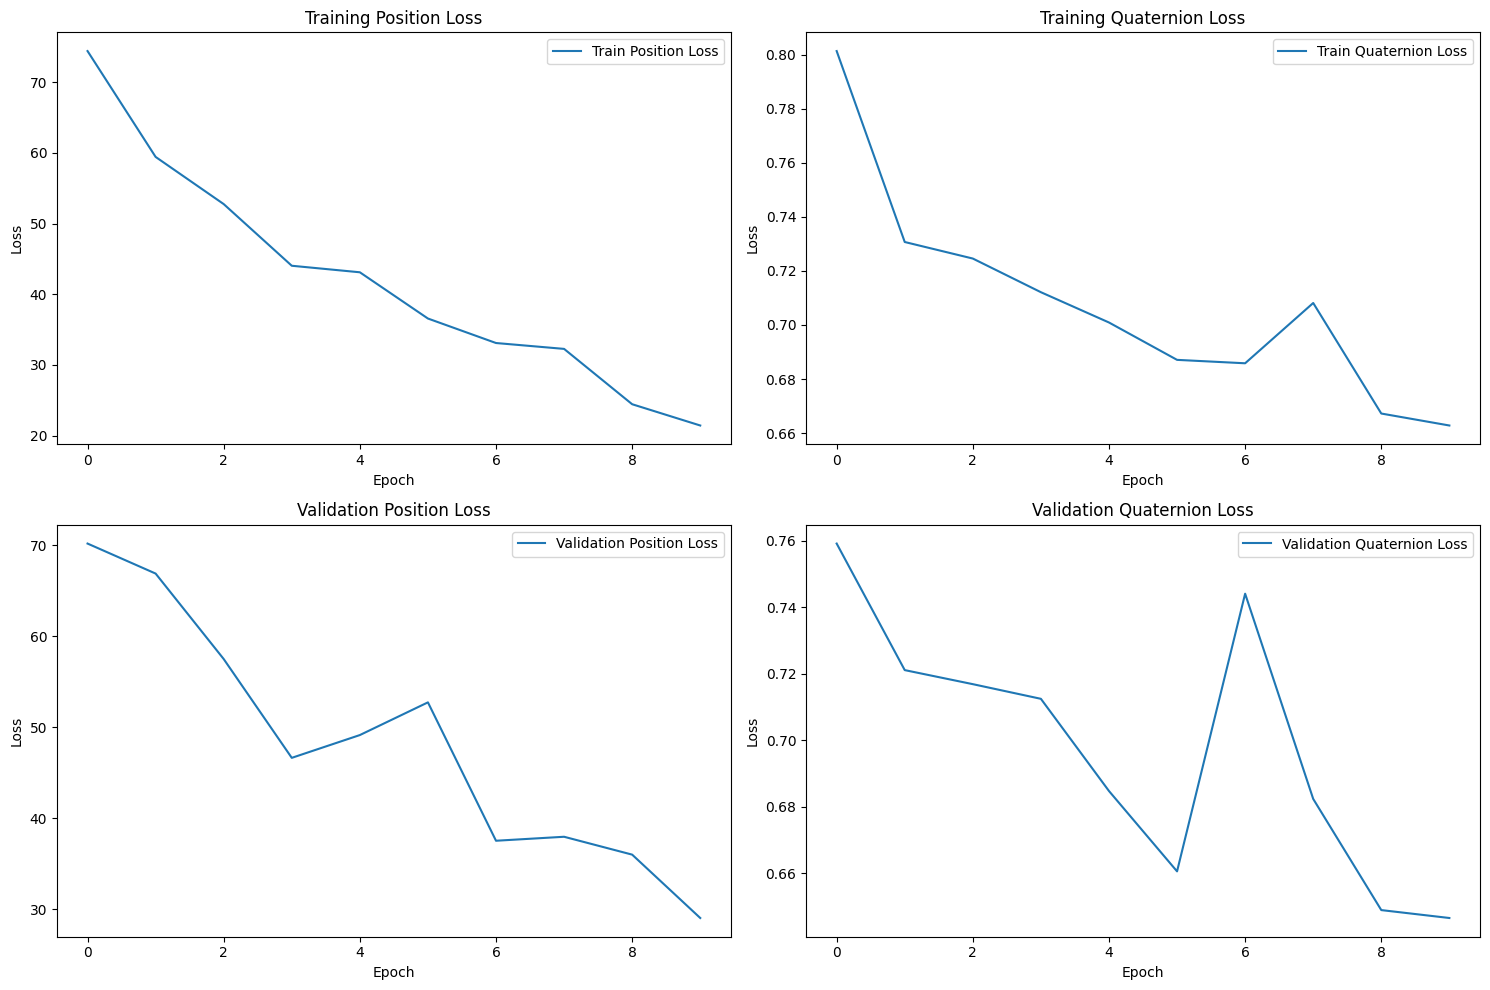

In [143]:
plot_training_metrics_AUE(loss_history_vit_10)

In [144]:
# Plot the training and validation metrics
actual_epochs = len(loss_history_vit_10.train_position_losses)
plot_metrics(loss_history_vit_10, actual_epochs)

In [145]:
true_positions = np.concatenate(true_positions_list, axis=0)
predicted_positions = np.concatenate(predicted_positions_list, axis=0)

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pose_comparison2(true_positions, predicted_positions, frame_number=None):
    plt.figure(figsize=(12, 8))

    if frame_number is not None:
        # 특정 프레임에 대해서만 시각화
        true_x, true_y = true_positions[frame_number, 0], true_positions[frame_number, 1]
        pred_x, pred_y = predicted_positions[frame_number, 0], predicted_positions[frame_number, 1]

        plt.scatter([true_x], [true_y], s=100, facecolors='none', edgecolors='b', label='True')  # 실제값
        plt.scatter([pred_x], [pred_y], s=100, facecolors='none', edgecolors=(1, 0, 0, 0.3), label='Predicted')  # 예측값, 투명도 0.3

        plt.title(f'Comparison at Frame {frame_number}')
    else:
        # 전체 데이터 시각화
        plt.scatter(true_positions[:, 0], true_positions[:, 1], s=100, facecolors='none', edgecolors='b', label='True')  # 실제값
        plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], s=100, facecolors='none', edgecolors=(1, 0, 0, 0.3), label='Predicted')  # 예측값, 투명도 0.3

        plt.title('Comparison of True and Predicted Poses')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

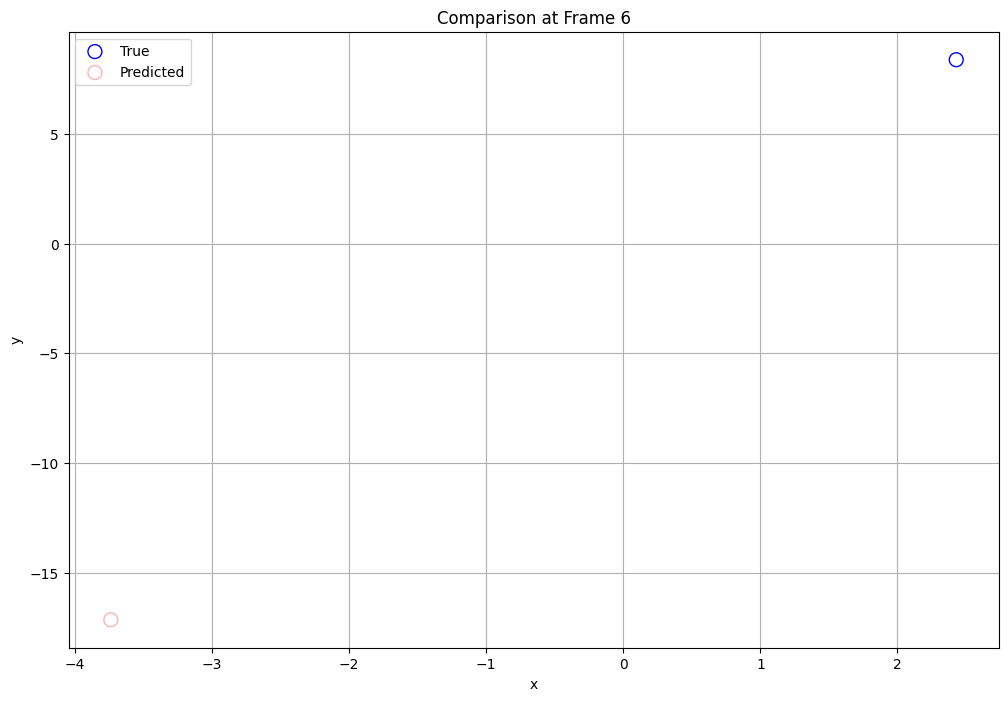

In [147]:
plot_pose_comparison2(true_positions, predicted_positions, frame_number=6)

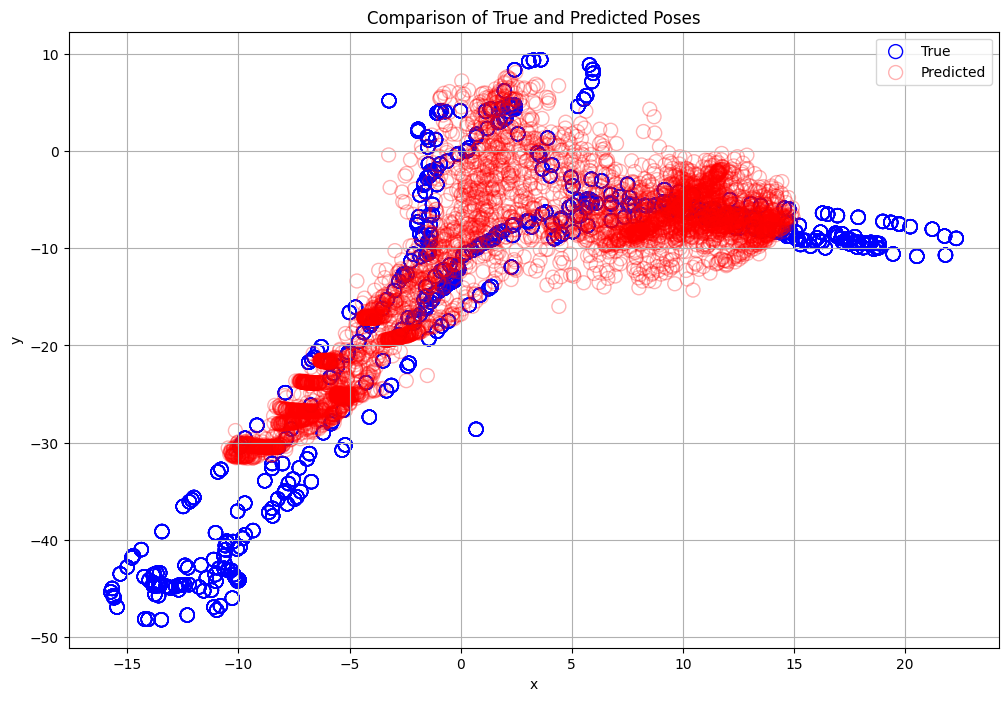

In [148]:
plot_pose_comparison2(true_positions, predicted_positions)

In [190]:
def compute_quaternion_loss2(y_true, y_pred):
    epsilon = 1e-7
    quaternion_true = y_true[:, 3:]
    quaternion_pred = y_pred[1]  # Use the second element for quaternion predictions
    quaternion_true = quaternion_true / (torch.norm(quaternion_true, dim=1, keepdim=True) + epsilon)
    quaternion_pred = quaternion_pred / (torch.norm(quaternion_pred, dim=1, keepdim=True) + epsilon)
    return torch.mean(torch.norm(quaternion_true - quaternion_pred, dim=1))

In [191]:
def evaluate_model2(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_position_loss = 0.0
    test_quaternion_loss = 0.0

    true_positions_list = []
    predicted_positions_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_inputs)
            loss = criterion(test_labels, outputs)

            position_loss = compute_position_loss2(test_labels, outputs)
            quaternion_loss = compute_quaternion_loss2(test_labels, outputs)

            test_loss += loss.item() * test_inputs.size(0)
            test_position_loss += position_loss.item() * test_inputs.size(0)
            test_quaternion_loss += quaternion_loss.item() * test_inputs.size(0)

            true_positions_list.append(test_labels.cpu().numpy())
            predicted_positions_list.append(torch.cat(outputs, dim=1).cpu().numpy())  # Concatenate position and quaternion

    test_loss = test_loss / len(test_loader.dataset)
    test_position_loss = test_position_loss / len(test_loader.dataset)
    test_quaternion_loss = test_quaternion_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Position Loss: {test_position_loss:.4f}, Test Quaternion Loss: {test_quaternion_loss:.4f}')

    # Measure and print the metrics
    measure_metrics(model, input_size)

    true_positions = np.concatenate(true_positions_list, axis=0)
    predicted_positions = np.concatenate(predicted_positions_list, axis=0)

    return test_loss, test_position_loss, test_quaternion_loss, true_positions, predicted_positions


In [192]:
class PoseNetLoss4_2(nn.Module):
    def __init__(self, beta_value=0.5):
        super(PoseNetLoss4_2, self).__init__()
        self.beta_value = beta_value

    def forward(self, y_true, y_pred):
        position_loss = compute_position_loss2(y_true, y_pred)
        quaternion_loss = compute_quaternion_loss2(y_true, y_pred)
        combined_loss = position_loss + self.beta_value * quaternion_loss
        return combined_loss
criterion = PoseNetLoss4_2()

In [193]:
# 모델 평가

test_loss, test_position_loss, test_quaternion_loss, true_positions, predicted_positions = evaluate_model2(model, test_loader, criterion)

Test Loss: 159.0753, Test Position Loss: 158.6999, Test Quaternion Loss: 0.7507
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
FLOPs: 16863457536.0
Parameters: 86242567.0
Latency: 0.007514 seconds


In [195]:
def visualize_predictions2(model, data_loader, num_batches=5):
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predictions = outputs[0].cpu().numpy()
            ground_truth = labels.cpu().numpy()

            all_predictions.append(predictions)
            all_ground_truths.append(ground_truth)

    # 배치 개수별로 시각화
    fig, axes = plt.subplots(num_batches, 1, figsize=(10, 5 * num_batches))

    if num_batches == 1:
        axes = [axes]

    for i in range(num_batches):
        predictions = all_predictions[i]
        ground_truth = all_ground_truths[i]

        # 위치 예측 결과 시각화 (x, y 좌표만)
        axes[i].scatter(ground_truth[:, 0], ground_truth[:, 1], label='Label')
        axes[i].scatter(predictions[:, 0], predictions[:, 1], label='Predictions')
        axes[i].legend()
        axes[i].set_title(f'Test Data Position Predictions')
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

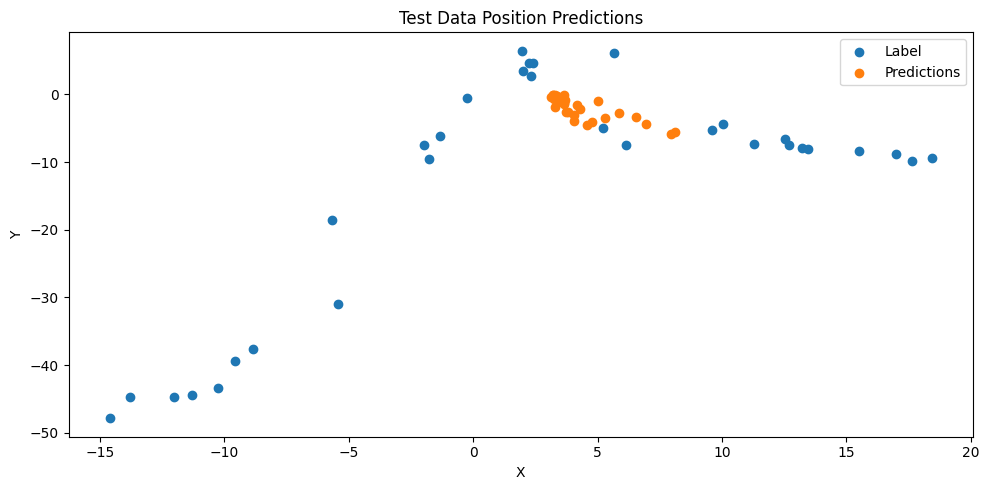

In [196]:
visualize_predictions2(model, test_loader, num_batches = 1)

(4) ResNet50 + AE

In [197]:
input_size = (3, 224, 224)

In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 클래스 정의
class PoseDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray((image * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

# ResNet-50 모델을 불러옵니다 (사전 학습된 가중치를 사용).
resnet50 = models.resnet50(pretrained=True)

# Feature extractor로 사용하기 위해 마지막 레이어(fc)를 제거합니다.
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNet50FeatureExtractor, self).__init__()
        # 모든 레이어를 가져옵니다, fc 레이어 제외
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle various input sizes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Autoencoder 정의
class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super(Autoencoder, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Linear(512, encoded_space_dim)
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(encoded_space_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 2048),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 모델 초기화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_extractor = ResNet50FeatureExtractor(resnet50).to(device)

# Feature extractor의 출력 크기를 확인합니다.
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output_features = feature_extractor(dummy_input)
feature_size = output_features.size(1)
print("Output features size:", output_features.size())

# Custom loss functions and metrics
def compute_position_loss2(y_true, y_pred):
    position_true = y_true[:, :3]
    position_pred = y_pred[:, :3]
    return torch.mean((position_pred - position_true) ** 2)

def compute_quaternion_loss(y_true, y_pred):
    epsilon = 1e-7
    quaternion_true = y_true[:, 3:]
    quaternion_pred = y_pred[:, 3:]
    quaternion_true = quaternion_true / (torch.norm(quaternion_true, dim=1, keepdim=True) + epsilon)
    quaternion_pred = quaternion_pred / (torch.norm(quaternion_pred, dim=1, keepdim=True) + epsilon)
    return torch.mean(torch.norm(quaternion_true - quaternion_pred, dim=1))

class PoseNetLoss4(nn.Module):
    def __init__(self, beta=0.5):
        super(PoseNetLoss4, self).__init__()
        self.beta_value = beta

    def forward(self, y_true, y_pred):
        position_loss = compute_position_loss2(y_true, y_pred)
        quaternion_loss = compute_quaternion_loss(y_true, y_pred)
        combined_loss = position_loss + self.beta_value * quaternion_loss
        return combined_loss

class PoseEstimationModel(nn.Module):
    def __init__(self, feature_extractor, autoencoder, feature_size):
        super(PoseEstimationModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.autoencoder = autoencoder
        # 포즈를 예측하기 위한 회귀 레이어 추가
        self.pose_regressor = nn.Sequential(
            nn.Linear(feature_size, 128),
            nn.Tanh(),
            nn.Dropout(p=0.5),  # Dropout 추가
            nn.Linear(128, 7)
            # x, y, z, quaternion_w, quaternion_x, quaternion_y, quaternion_z
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        encoded, _ = self.autoencoder(features)
        pose = self.pose_regressor(encoded)
        return pose

# LossHistory 클래스 정의
class LossHistory:
    def __init__(self):
        self.train_position_losses = []
        self.train_quaternion_losses = []
        self.val_position_losses = []
        self.val_quaternion_losses = []

    def on_epoch_end(self, train_position_loss, train_quaternion_loss, val_position_loss, val_quaternion_loss):
        self.train_position_losses.append(train_position_loss)
        self.train_quaternion_losses.append(train_quaternion_loss)
        self.val_position_losses.append(val_position_loss)
        self.val_quaternion_losses.append(val_quaternion_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Output features size: torch.Size([1, 2048])


In [199]:
# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta

        self.best_loss = None
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if (self.counter >= self.patience):
                print(f"Early stopping triggered. Restoring best model from epoch with validation loss {self.best_loss:.4f}")
                model.load_state_dict(self.best_model)
                return True
        return False

In [200]:
import numpy as np
from PIL import Image

input_images = []
labels = []
#quarternion 변환된 데이터 사용(orientation : roll, pitch, yaw -> w, x, y, z)
#orientation은 radian
'''
# Binding images and coordinates into pairs
for image_path, coord in zip(image_file_paths, coordinates):
    # Image loading and preprocessing
    image = Image.open('/content/drive/MyDrive/image/frames_resized/' + image_path) # Resize image

    #image = np.array(image) / 255.0 # Image normalization
    image = np.divide(np.array(image), 255.0)
    # Add image and coordinates to the list
    input_images.append(image)
    labels.append(coord)

# Convert list to NumPy array
input_images = np.array(input_images)
labels = np.array(labels)
np.savez('/content/drive/MyDrive/data/data_quaternion.npz', input_images=input_images, labels=labels)
'''


loaded_data = np.load('/content/drive/MyDrive/data/data_224_quaternion.npz')
#loaded_data = np.load('/content/drive/MyDrive/24-1딥러닝/data/data_quaternion.npz')
input_images = loaded_data['input_images']
labels = loaded_data['labels']

In [201]:
from torchvision import models, transforms
# 데이터 전처리
data_transforms = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [202]:
x_train_val, x_test_224, y_train_val, y_test_224 = train_test_split(input_images, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [203]:
# 데이터셋 및 데이터로더 초기화
train_dataset = PoseDataset(x_train, y_train, transform=data_transforms)
val_dataset = PoseDataset(x_val, y_val, transform=data_transforms)
test_224_dataset = PoseDataset(x_test_224, y_test_224, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_224_loader = DataLoader(test_224_dataset, batch_size=32, shuffle=False)

In [204]:
# 모델 초기화
encoded_space_dim = 128  # 잠재 공간의 차원
autoencoder = Autoencoder(encoded_space_dim).to(device)
model = PoseEstimationModel(feature_extractor, autoencoder, encoded_space_dim).to(device)
criterion = PoseNetLoss4()

# 손실 함수 및 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(patience=10, min_delta=0.01)
beta_adjustment = DynamicBetaAdjustment(initial_beta=0.5)
loss_history_final_100 = LossHistory()
true_positions_list = []
predicted_positions_list = []

# 훈련 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, beta_adjustment, loss_history_final_100, num_epochs=100):
    # For storing true and predicted values
    true_positions_list = []
    predicted_positions_list = []

    stop_training = False
    actual_epochs = 0  # To keep track of the actual number of epochs run

    for epoch in range(num_epochs):
        if stop_training:
            break
        model.train()
        running_loss = 0.0
        train_position_loss = 0.0
        train_quaternion_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(labels, outputs)

            position_loss = compute_position_loss2(labels, outputs)
            quaternion_loss = compute_quaternion_loss(labels, outputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_position_loss += position_loss.item() * inputs.size(0)
            train_quaternion_loss += quaternion_loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_position_loss /= len(train_loader.dataset)
        train_quaternion_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Position Loss: {train_position_loss:.4f}, Quaternion Loss: {train_quaternion_loss:.4f}')

        # Validation step
        model.eval()
        val_loss = 0.0
        val_position_loss = 0.0
        val_quaternion_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_labels, val_outputs).item() * val_inputs.size(0)
                val_position_loss += compute_position_loss2(val_labels, val_outputs).item() * val_inputs.size(0)
                val_quaternion_loss += compute_quaternion_loss(val_labels, val_outputs).item() * val_inputs.size(0)

                true_positions_list.append(labels.cpu().numpy())
                predicted_positions_list.append(outputs.cpu().numpy())
        val_loss = val_loss / len(val_loader.dataset)
        val_position_loss = val_position_loss / len(val_loader.dataset)
        val_quaternion_loss = val_quaternion_loss / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Position Loss: {val_position_loss:.4f}, Validation Quaternion Loss: {val_quaternion_loss:.4f}')

        # 손실 기록
        loss_history_final_100.on_epoch_end(train_position_loss, train_quaternion_loss, val_position_loss, val_quaternion_loss)

        # Learning rate adjustment
        scheduler.step(val_loss)

        # Early stopping check
        if early_stopping(val_loss, model):
            break

        # Beta 값 동적 조정
        beta_adjustment.on_epoch_end(epoch, None)
        criterion.beta_value = beta_adjustment.beta
    # 수치 출력
    measure_metrics(model, input_size)
    return model, predicted_positions_list, true_positions_list

In [205]:
# 모델 훈련
model, predicted_positions_list, true_positions_list = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, beta_adjustment, loss_history_final_100, num_epochs=10)

# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/model/resnet_autoencoder_final_10.pth')

Epoch 1/10, Loss: 121.1230, Position Loss: 120.5886, Quaternion Loss: 1.0688
Epoch 1/10, Validation Loss: 122.8874, Validation Position Loss: 122.3707, Validation Quaternion Loss: 1.0335
Epoch 1: Adjusted beta value to 0.475
Epoch 2/10, Loss: 99.7606, Position Loss: 99.2606, Quaternion Loss: 1.0526
Epoch 2/10, Validation Loss: 115.1446, Validation Position Loss: 114.6794, Validation Quaternion Loss: 0.9792
Epoch 2: Adjusted beta value to 0.45125
Epoch 3/10, Loss: 92.9495, Position Loss: 92.4921, Quaternion Loss: 1.0138
Epoch 3/10, Validation Loss: 109.2546, Validation Position Loss: 108.8598, Validation Quaternion Loss: 0.8749
Epoch 3: Adjusted beta value to 0.42868749999999994
Epoch 4/10, Loss: 88.6811, Position Loss: 88.2685, Quaternion Loss: 0.9626
Epoch 4/10, Validation Loss: 104.5882, Validation Position Loss: 104.2318, Validation Quaternion Loss: 0.8313
Epoch 4: Adjusted beta value to 0.40725312499999994
Epoch 5/10, Loss: 84.9414, Position Loss: 84.5662, Quaternion Loss: 0.9212
E

In [206]:
# Plot the training and validation metrics
actual_epochs = len(loss_history_final_100.train_position_losses)
plot_metrics(loss_history_final_100, actual_epochs)

In [207]:
#loss_visualization_function

import matplotlib.pyplot as plt

def plot_training_metrics_AUE(history):
    epochs = list(range(len(history.train_position_losses)))

    # Create subplots with 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training position loss
    axs[0, 0].plot(epochs, history.train_position_losses, label='Train Position Loss')
    axs[0, 0].set_title('Training Position Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot training quaternion loss
    axs[0, 1].plot(epochs, history.train_quaternion_losses, label='Train Quaternion Loss')
    axs[0, 1].set_title('Training Quaternion Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Plot validation position loss
    axs[1, 0].plot(epochs, history.val_position_losses, label='Validation Position Loss')
    axs[1, 0].set_title('Validation Position Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Plot validation quaternion loss
    axs[1, 1].plot(epochs, history.val_quaternion_losses, label='Validation Quaternion Loss')
    axs[1, 1].set_title('Validation Quaternion Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

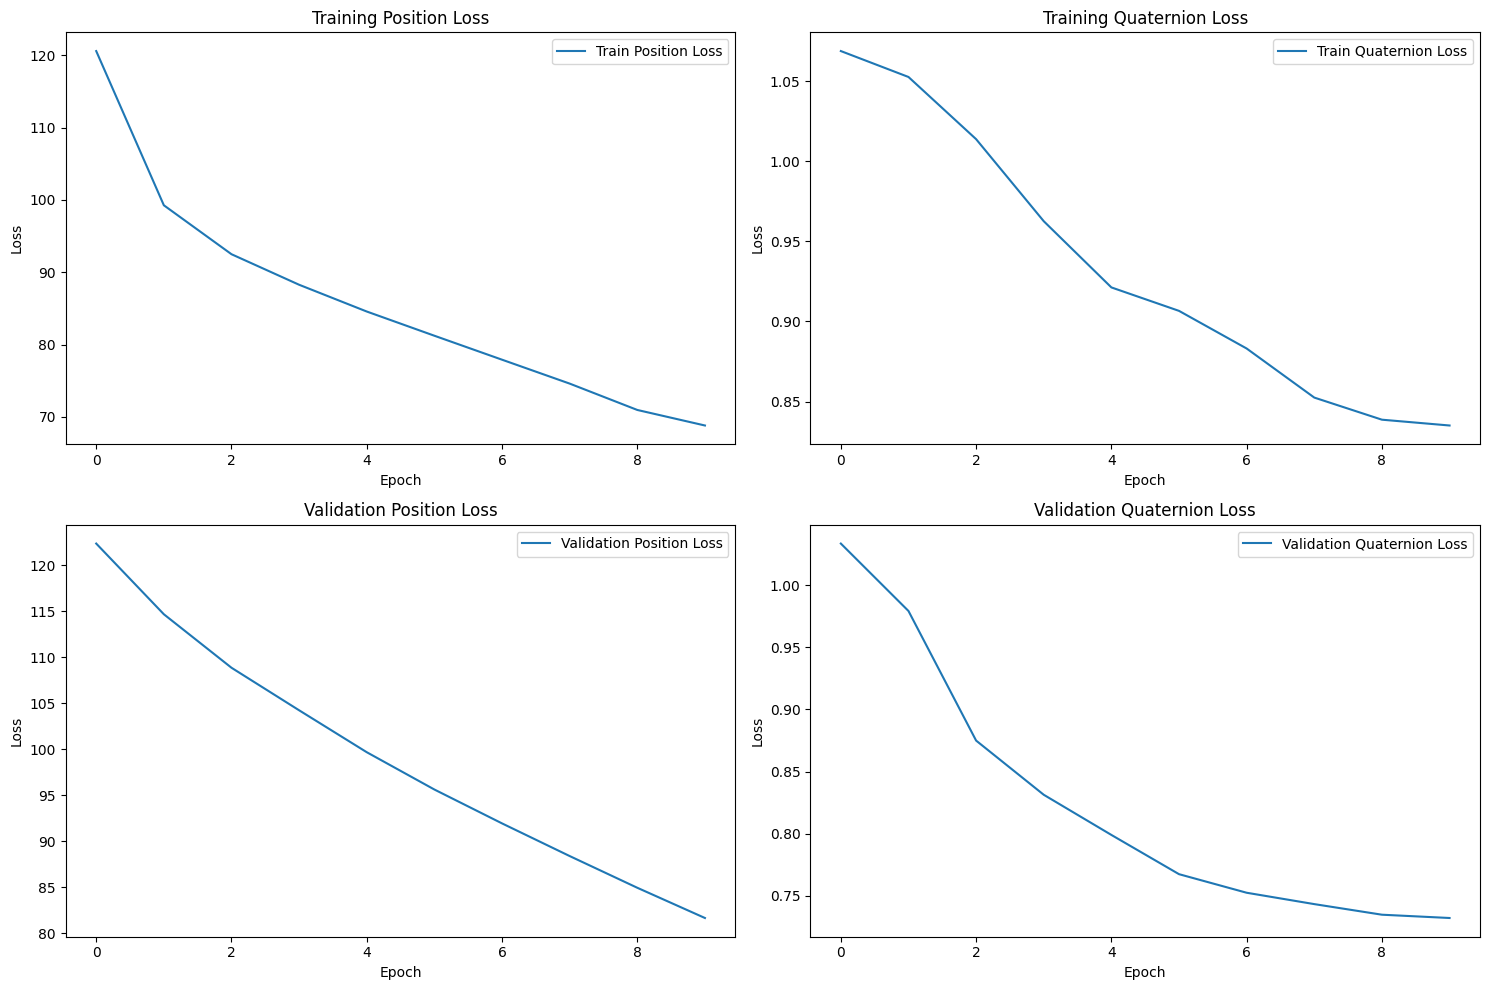

In [208]:
plot_training_metrics_AUE(loss_history_final_100)

In [209]:
true_positions = np.vstack(true_positions_list)
predicted_positions = np.vstack(predicted_positions_list)

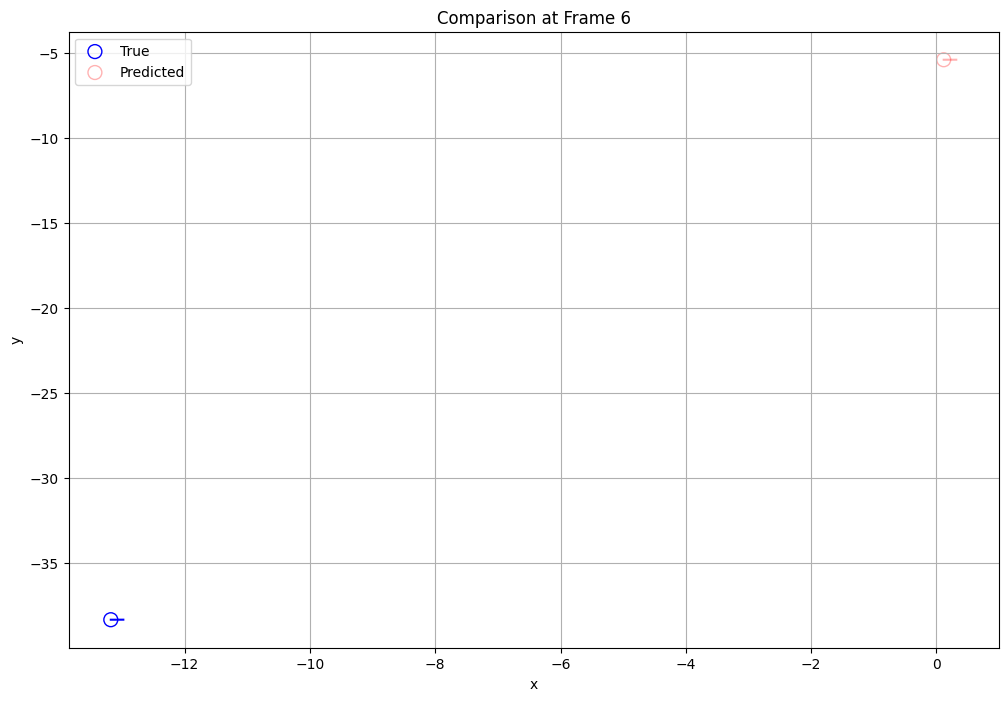

In [210]:
plot_pose_comparison(true_positions, predicted_positions, frame_number=6)

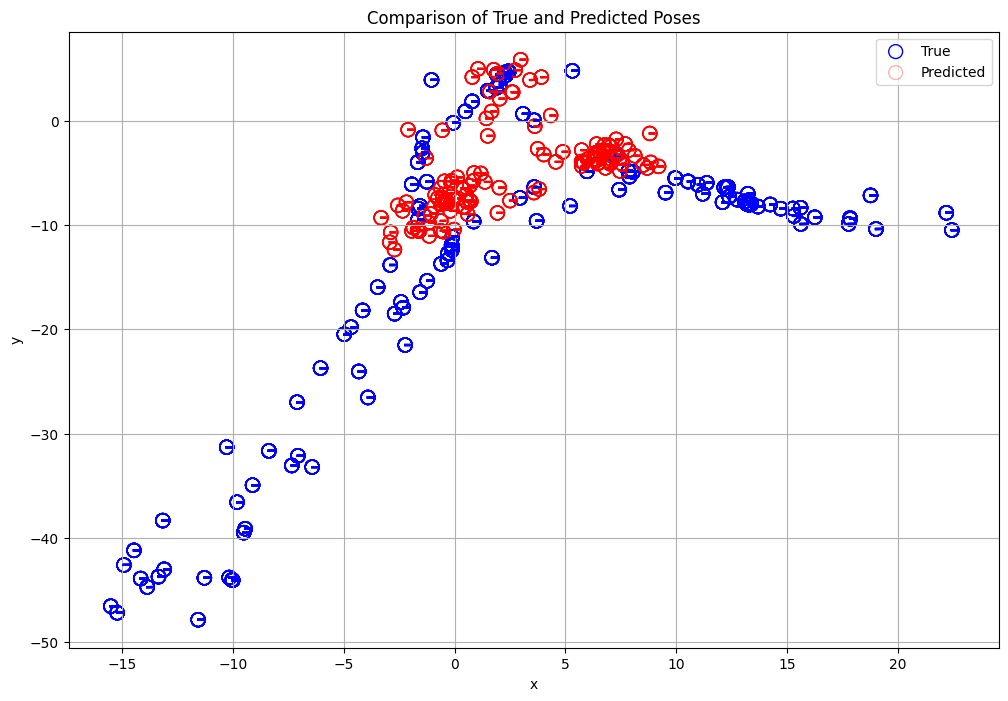

In [211]:
plot_pose_comparison(true_positions, predicted_positions)

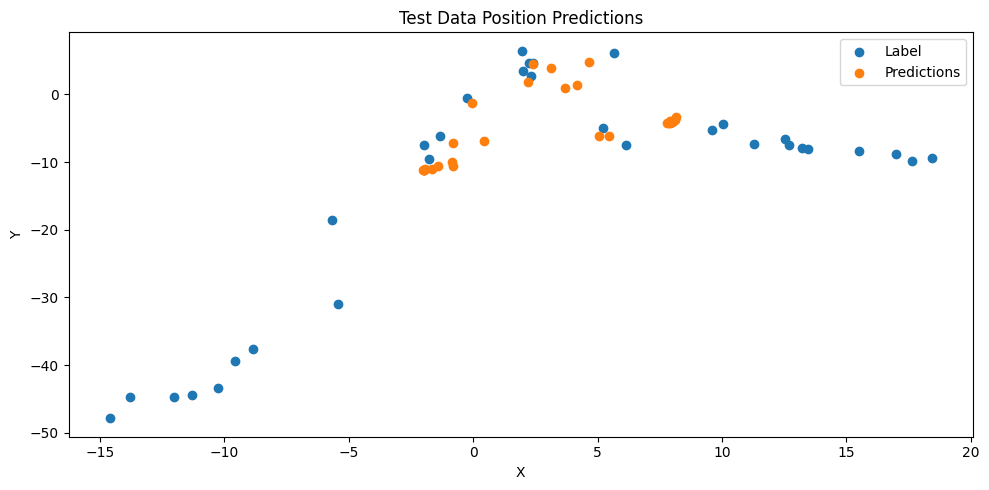

In [212]:
visualize_predictions(model, test_loader, num_batches = 1)

# 100epcoh

In [ ]:
true_positions_list = []
predicted_positions_list = []

In [ ]:
# 모델 훈련
model, predicted_positions_list, true_positions_list = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, beta_adjustment, loss_history_final_100, num_epochs=100)

# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/model/resnet_autoencoder_final_100.pth')

Epoch 1/100, Loss: 123.7614, Position Loss: 123.1794, Quaternion Loss: 1.1641
Epoch 1/100, Validation Loss: 126.2721, Validation Position Loss: 125.7659, Validation Quaternion Loss: 1.0125
Epoch 1: Adjusted beta value to 0.475
Epoch 2/100, Loss: 102.6985, Position Loss: 102.1871, Quaternion Loss: 1.0767
Epoch 2/100, Validation Loss: 118.4794, Validation Position Loss: 118.0315, Validation Quaternion Loss: 0.9431
Epoch 2: Adjusted beta value to 0.45125
Epoch 3/100, Loss: 96.4112, Position Loss: 95.9541, Quaternion Loss: 1.0130
Epoch 3/100, Validation Loss: 112.8713, Validation Position Loss: 112.4914, Validation Quaternion Loss: 0.8419
Epoch 3: Adjusted beta value to 0.42868749999999994
Epoch 4/100, Loss: 92.0566, Position Loss: 91.6426, Quaternion Loss: 0.9657
Epoch 4/100, Validation Loss: 107.9304, Validation Position Loss: 107.5945, Validation Quaternion Loss: 0.7837
Epoch 4: Adjusted beta value to 0.40725312499999994
Epoch 5/100, Loss: 87.6118, Position Loss: 87.2295, Quaternion Los

RuntimeError: Parent directory /content/drive/MyDrive/model does not exist.

In [ ]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=67f0296bb5fa46ade1f8c82d7bdb90193ca33bb071ec1d090f0fdf482887e523
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

# Move the dummy input to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1, 3, 224, 224).to(device)

output = model(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization to a file
dot.render("simple_nn_structure", format="png")

'simple_nn_structure.png'

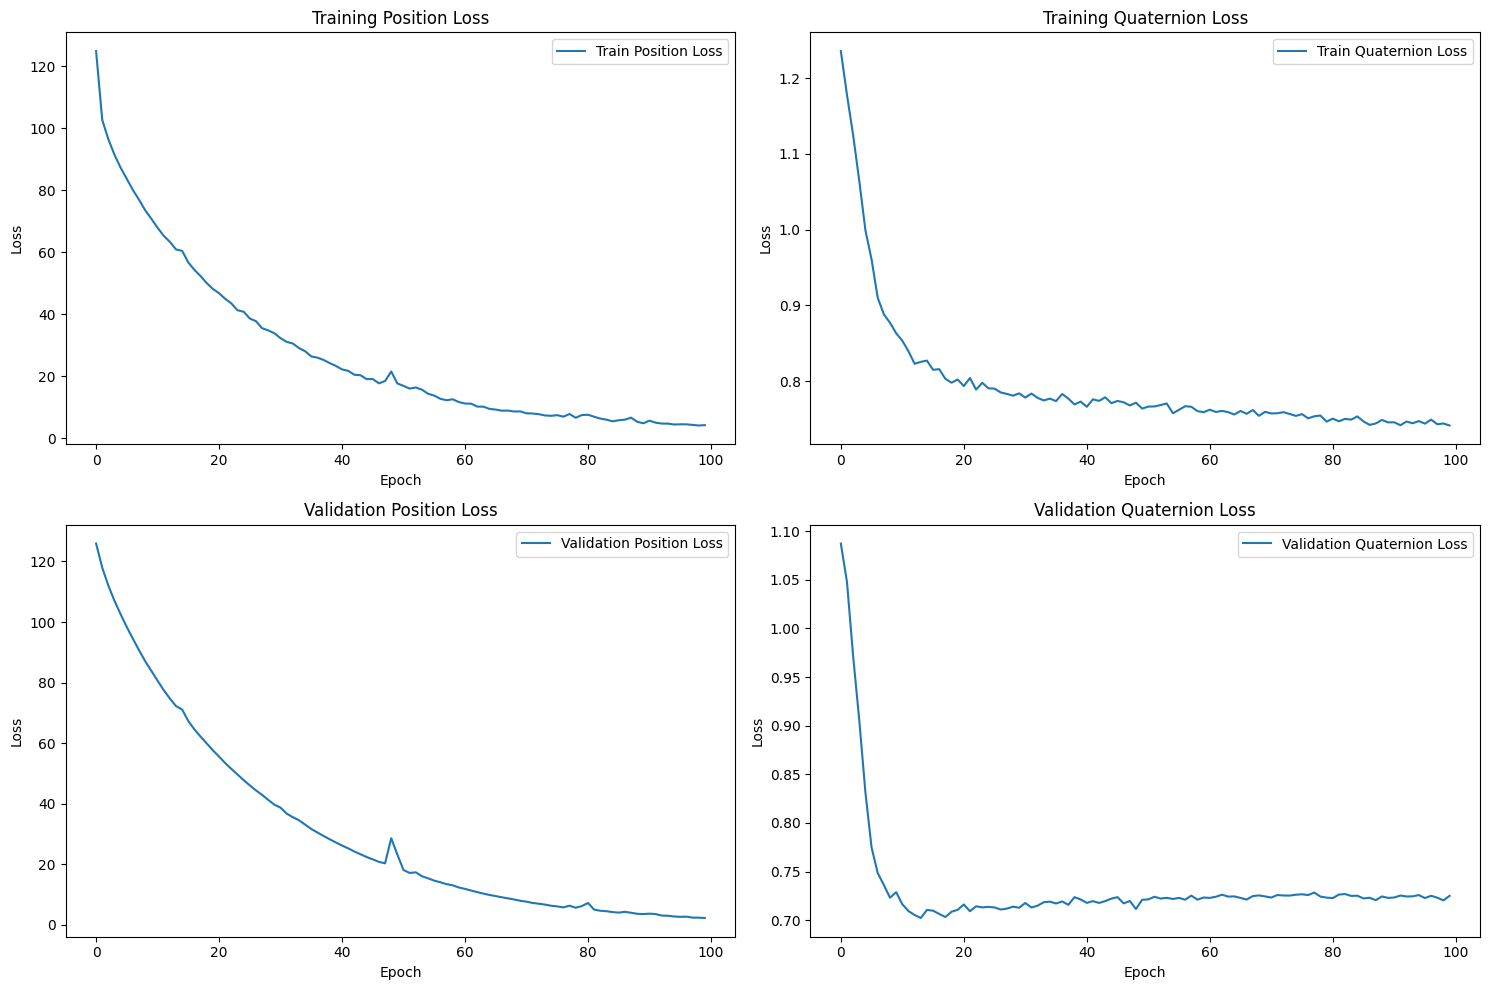

In [ ]:
plot_training_metrics_AUE(loss_history_final_100)

In [ ]:
# Plot the training and validation metrics
actual_epochs = len(loss_history_final_100.train_position_losses)
plot_metrics(loss_history_final_100, actual_epochs)

In [ ]:
true_positions = np.vstack(true_positions_list)
predicted_positions = np.vstack(predicted_positions_list)

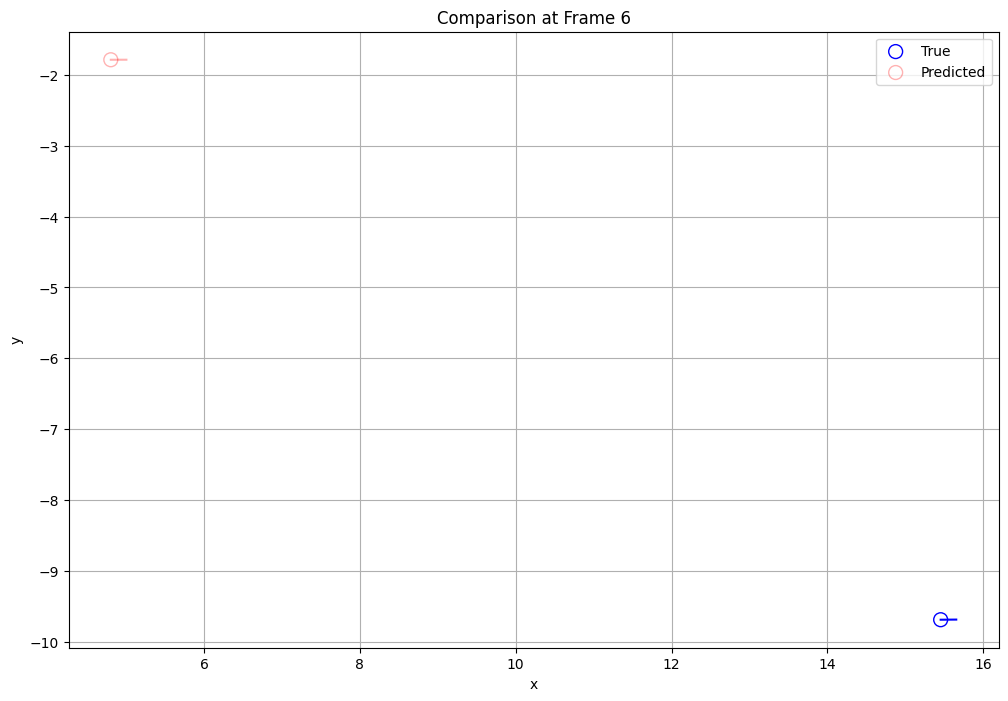

In [ ]:
plot_pose_comparison(true_positions, predicted_positions, frame_number=6)

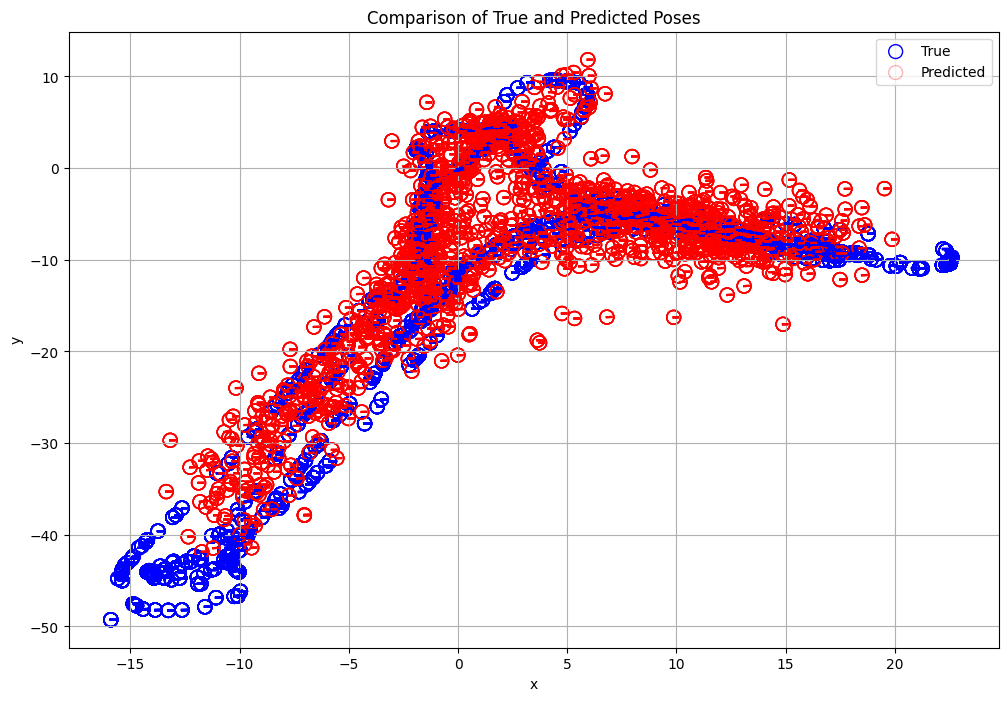

In [ ]:
plot_pose_comparison(true_positions, predicted_positions)

In [ ]:
# 저장된 모델 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/model/resnet_autoencoder_final_100.pth'))

# 모델 평가
test_loss, test_position_loss, test_quaternion_loss, true_positions, predicted_positions = evaluate_model(model, test_224_loader, criterion)

Test Loss: 2.2439, Test Position Loss: 2.1705, Test Quaternion Loss: 0.7337
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPs: 4133940096.0
Parameters: 25756871.0
Latency: 0.011227 seconds


In [ ]:
def visualize_predictions(model, data_loader, num_batches=5):
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predictions = outputs.cpu().numpy()
            ground_truth = labels.cpu().numpy()

            all_predictions.append(predictions)
            all_ground_truths.append(ground_truth)

    # 배치 개수별로 시각화
    fig, axes = plt.subplots(num_batches, 1, figsize=(10, 5 * num_batches))

    if num_batches == 1:
        axes = [axes]

    for i in range(num_batches):
        predictions = all_predictions[i]
        ground_truth = all_ground_truths[i]

        # 위치 예측 결과 시각화 (x, y 좌표만)
        axes[i].scatter(ground_truth[:, 0], ground_truth[:, 1], label='Label')
        axes[i].scatter(predictions[:, 0], predictions[:, 1], label='Predictions')
        axes[i].legend()
        axes[i].set_title(f'Test Data Position Predictions')
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

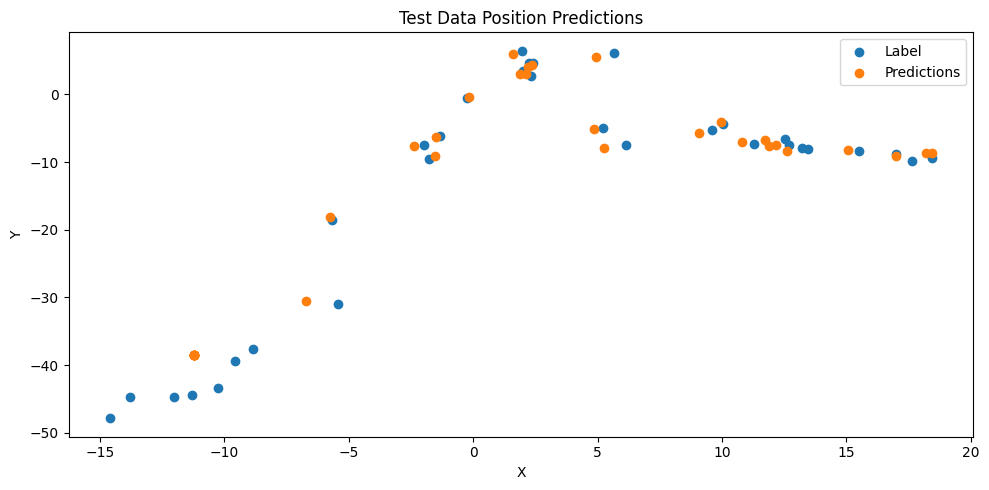

In [ ]:
visualize_predictions(model, test_224_loader, num_batches = 1)